In [136]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt

In [138]:
ratings_data_path = 'Ratings Data.xlsx'
ratings_data = pd.read_excel(ratings_data_path)
Inflation_data = pd.read_excel('Inflation.xlsx')
Treasury_10Y = pd.read_excel('10yr US Treasury.xlsx')

In [139]:
# Read the Excel file without headers to inspect raw data
raw_data1 = pd.read_excel('DATA DUMP.xlsx', sheet_name="Sheet1", header=None)

# Extract the list of column headers from row 6 (index 5)
column_headers = raw_data1.iloc[5, 1:20].tolist()

# Extract potential company names from row 4 (index 3), spaced 19 columns apart
company_names = raw_data1.iloc[3, 1::19].dropna().tolist()

# Initialize a dictionary to store DataFrames for each company
company_dataframes = {}

desired_columns = ['BB_1YR_DEFAULT_PROB', 'BB_2Y_DEFAULT_PROB', 'BB_3Y_DEFAULT_PROB',
                   'BB_4Y_DEFAULT_PROB', 'BB_5Y_DEFAULT_PROB', 'RSK_BB_IMPLIED_CDS_SPREAD']
# Iterate through the identified company names and corresponding column indices
for (index), company_name in enumerate(company_names):
    # Calculate the starting column index for each company's data (spaced 19 columns apart)
    if index ==0:
        col_start = 1
        # Extract data starting from row 7 (index 6)
        dates = pd.to_datetime(raw_data1.iloc[6:, 0], errors='coerce')  # Date column
        data_block = raw_data1.iloc[6:, col_start:col_start + 19]       # Data block for the company
    else:
        col_start = index*19
        # Extract data starting from row 7 (index 6)
        dates = pd.to_datetime(raw_data1.iloc[6:, 0], errors='coerce')  # Date column
        data_block = raw_data1.iloc[6:, (col_start+1) :col_start + 20]       # Data block for the company

    

    # Assign column headers to the data block
    data_block.columns = column_headers[:19]
    data_block = data_block[desired_columns]
    # Add the Date column separately
    data_block.insert(0, 'Date', dates)
    # Store the DataFrame in the dictionary with the company name as the key
    company_dataframes[company_name] = data_block

# Display the list of successfully processed company names
#list(company_dataframes.keys())

In [140]:
# Create a new dictionary with modified keys
company_dataframes_cleaned = {}

# Iterate over the original dictionary
for full_key, dataframe in company_dataframes.items():
    # Extract the ticker from the key (everything before the first space)
    ticker = full_key.split(' ')[0]
    # Add the DataFrame to the new dictionary with the cleaned key
    company_dataframes_cleaned[ticker] = dataframe

# Replace the original dictionary with the cleaned one
company_dataframes = company_dataframes_cleaned

In [141]:
# Add BB_0YR_DEFAULT_PROB column in the correct position for each company's DataFrame
for company_name, df in company_dataframes.items():
    # Find the index of 'MATURITY' and calculate the position to insert
    maturity_index = df.columns.get_loc('Date') + 1  # Insert right after 'MATURITY'

    # Insert BB_0YR_DEFAULT_PROB column with zeros at the correct position
    df.insert(maturity_index, 'BB_0YR_DEFAULT_PROB', 0)
    
    # Merge with Treasury_10Y on Date
    df = pd.merge(df, Treasury_10Y, on='Date', how='left')
    df = pd.merge(df,Inflation_data,on='Date', how='left')
    df = df.dropna()
    # Update the company's DataFrame in the dictionary
    company_dataframes[company_name] = df

In [142]:
company_dataframes

{'RTN':            Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
 3915 2005-01-03                    0            0.000004           0.000293   
 3916 2005-01-04                    0            0.000007           0.000385   
 3917 2005-01-05                    0            0.000007           0.000376   
 3918 2005-01-06                    0            0.000007           0.000386   
 3919 2005-01-07                    0            0.000007           0.000385   
 ...         ...                  ...                 ...                ...   
 9062 2024-09-25                    0            0.010324           0.024333   
 9063 2024-09-26                    0            0.010324           0.024333   
 9064 2024-09-27                    0            0.010324           0.024333   
 9065 2024-09-30                    0            0.010324           0.024333   
 9066 2024-10-01                    0            0.010324           0.024333   
 
      BB_3Y_DEFAULT_PROB BB_4Y_

In [7]:
Inflation_data

Date  Pct_Change
0     1947-02-01    0.006518
1     1947-02-02    0.006913
2     1947-02-03    0.007308
3     1947-02-04    0.007703
4     1947-02-05    0.008097
...          ...         ...
28363 2024-09-27    0.002355
28364 2024-09-28    0.002376
28365 2024-09-29    0.002398
28366 2024-09-30    0.002419
28367 2024-10-01    0.002441

[28368 rows x 2 columns]

In [8]:
# Re-reading all the DD files to ensure they are loaded correctly
dd_file_paths = {
    'BAC': 'BAC_DDDP.csv',
    'BWA': 'BWA_DDDP.csv',
    'CPB': 'CPB_DDDP.csv',
    'D': 'D_DDDP.csv',
    'EMR': 'EMR_DDDP.csv',
    'GILD': 'GILD_DDDP.csv',
    'HAL': 'HAL_DDDP.csv',
    'HES': 'HES_DDDP.csv',
    'JNPR': 'JNPR_DDDP.csv',
    'KEY': 'KEY_DDDP.csv',
    'LMT': 'LMT_DDDP.csv',
    'PARA': 'PARA_DDDP.csv',
    'RTN': 'RTN_DDDP.csv',
    'STX': 'STX_DDDP.csv',
    'TXT': 'TXT_DDDP.csv',
    'WELL': 'WELL_DDDP.csv'
}

# Read and store the data in a dictionary
dd_dataframes = {name: pd.read_csv(path) for name, path in dd_file_paths.items()}
dd_dataframes

{'BAC':             Date  Current_Market_Cap        Assets   Liabilities  \
 0     1997-01-15          84245.2848  18336.630545  14618.054428   
 1     1997-01-16          84645.9758  18343.681105  14622.683091   
 2     1997-01-17          85146.8395  18350.747558  14627.451232   
 3     1997-01-20          85547.5305  18372.009613  14642.539034   
 4     1997-01-21          85547.5305  18379.106978  14647.811593   
 ...          ...                 ...           ...           ...   
 7255  2024-11-06         348425.4626  16203.723982   9100.264116   
 7256  2024-11-07         343514.8196  16193.777307   9085.011671   
 7257  2024-11-08         346277.0563  16183.641428   9069.503047   
 7258  2024-11-11         353566.2919  16152.084062   9021.422057   
 7259  2024-11-12         351878.2631  16141.176860   9004.870674   
 
       Log_Equity_Returns  Daily_Equity_Volatility  Risk_Free_Rate  \
 0                    NaN                 0.298396          0.0653   
 1               0.0047

In [9]:
# Ensure the Date columns in both dataframes are in datetime64[ns] format
for ticker in company_dataframes.keys():
    # Convert Date column in company_dataframes to datetime
    company_dataframes[ticker]['Date'] = pd.to_datetime(company_dataframes[ticker]['Date'], errors='coerce')
    
for ticker in dd_dataframes.keys():
    # Convert Date column in dd_dataframes to datetime
    dd_dataframes[ticker]['Date'] = pd.to_datetime(dd_dataframes[ticker]['Date'], errors='coerce')

# Initialize hmm_data dictionary
hmm_data = {}

# Iterate through the keys in company_dataframes
for ticker in company_dataframes.keys():
    if ticker in dd_dataframes:
        # Merge the DataFrames on the 'Date' column
        merged_df = pd.merge(
            company_dataframes[ticker],
            dd_dataframes[ticker],
            on='Date',
            how='left',  # Use the appropriate join type
            suffixes=('_preprocessed', '_company')  # Differentiate overlapping columns
        )
        # Store the merged DataFrame in hmm_data
        hmm_data[ticker] = merged_df
hmm_data

{'RTN':            Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
 0    2005-01-03                    0            0.000004           0.000293   
 1    2005-01-04                    0            0.000007           0.000385   
 2    2005-01-05                    0            0.000007           0.000376   
 3    2005-01-06                    0            0.000007           0.000386   
 4    2005-01-07                    0            0.000007           0.000385   
 ...         ...                  ...                 ...                ...   
 4938 2024-09-25                    0            0.010324           0.024333   
 4939 2024-09-26                    0            0.010324           0.024333   
 4940 2024-09-27                    0            0.010324           0.024333   
 4941 2024-09-30                    0            0.010324           0.024333   
 4942 2024-10-01                    0            0.010324           0.024333   
 
      BB_3Y_DEFAULT_PROB BB_4Y_

In [10]:
hmm_data['HAL']

Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
0    2005-01-03                    0            0.000129           0.002243   
1    2005-01-04                    0            0.000126           0.002214   
2    2005-01-05                    0            0.000127           0.002224   
3    2005-01-06                    0            0.000121            0.00216   
4    2005-01-07                    0            0.000122           0.002171   
...         ...                  ...                 ...                ...   
4938 2024-09-25                    0            0.000056            0.00121   
4939 2024-09-26                    0            0.000063           0.001298   
4940 2024-09-27                    0            0.000061           0.001271   
4941 2024-09-30                    0            0.000056           0.001209   
4942 2024-10-01                    0            0.000053           0.001175   

     BB_3Y_DEFAULT_PROB BB_4Y_DEFAULT_PROB BB_5Y_DEFAULT_PROB  \
0              0.006399           0.010811            0.01545   
1              0.006332           0.010708           0.015315   
2              0.006352           0.010735           0.015346   
3              0.006218           0.010543            0.01511   
4               0.00624           0.010571           0.015142   
...                 ...                ...                ...   
4938           0.003772           0.006698           0.010046   
4939           0.003968           0.006992           0.010423   
4940           0.003911            0.00691           0.010323   
4941            0.00377           0.006696           0.010043   
4942           0.003693           0.006583           0.009901   

     RSK_BB_IMPLIED_CDS_SPREAD  Rate  Pct_Change  ...         Assets  \
0                         46.8  4.23   -0.000219  ...   45446.655403   
1                         46.6  4.29   -0.000067  ...   45457.863867   
2                         46.7  4.29    0.000084  ...   45469.864997   
3                         46.3  4.29    0.000236  ...   45482.637395   
4                         46.4  4.29    0.000387  ...   45496.159662   
...                        ...   ...         ...  ...            ...   
4938                      78.5  3.79    0.002312  ...  100042.435616   
4939                      79.8  3.79    0.002334  ...  100000.631390   
4940                      79.4  3.75    0.002355  ...   99957.501864   
4941                      79.5  3.81    0.002419  ...   99820.000000   
4942                        79  3.74    0.002441  ...   99771.407788   

       Liabilities  Log_Equity_Returns  Daily_Equity_Volatility  \
0     33765.301185           -0.031584                 0.269675   
1     33777.953426            0.001052                 0.269662   
2     33791.830353           -0.012692                 0.268535   
3     33806.901223            0.017672                 0.269315   
4     33823.135291           -0.007084                 0.269143   
...            ...                 ...                      ...   
4938  72583.215681           -0.037394                 0.291507   
4939  72527.601064           -0.037407                 0.296977   
4940  72470.390325            0.029758                 0.301783   
4941  72289.000000            0.013865                 0.303011   
4942  72225.223394            0.029843                 0.306957   

      Risk_Free_Rate    Asset_Value  Asset_Volatility  Equity_Value_Model  \
0             0.0423   45446.655403          0.077614        13079.843783   
1             0.0429   45457.863867          0.077701        13098.345555   
2             0.0429   45469.864997          0.077348        13097.052160   
3             0.0429   45482.637395          0.077541        13095.386791   
4             0.0429   45496.159662          0.077456        13093.356659   
...              ...            ...               ...                 ...   
4938          0.0379  100042.435616          0.087876        30158.68282

In [11]:
all_data_list1 = []
# Iterate through each DataFrame in the dictionary and add a 'Company' column
for company_name, df in hmm_data.items():
    # Add the 'Company' column to the DataFrame
    df['Company'] = company_name
    # Append the modified DataFrame to the list
    all_data_list1.append(df)

# Concatenate all DataFrames vertically
HMM_DATA = pd.concat(all_data_list1, ignore_index=True)
HMM_DATA

Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
0     2005-01-03                    0            0.000004           0.000293   
1     2005-01-04                    0            0.000007           0.000385   
2     2005-01-05                    0            0.000007           0.000376   
3     2005-01-06                    0            0.000007           0.000386   
4     2005-01-07                    0            0.000007           0.000385   
...          ...                  ...                 ...                ...   
78872 2024-09-25                    0            0.000001           0.000109   
78873 2024-09-26                    0            0.000001           0.000114   
78874 2024-09-27                    0            0.000001           0.000114   
78875 2024-09-30                    0            0.000001           0.000114   
78876 2024-10-01                    0            0.000001           0.000113   

      BB_3Y_DEFAULT_PROB BB_4Y_DEFAULT_PROB BB_5Y_DEFAULT_PROB  \
0               0.001383            0.00283           0.004748   
1               0.001675           0.003332           0.005458   
2                0.00165           0.003289           0.005399   
3               0.001679           0.003338           0.005468   
4               0.001676           0.003332           0.005458   
...                  ...                ...                ...   
78872           0.000682           0.001559           0.002885   
78873           0.000704           0.001602           0.002955   
78874           0.000702           0.001601           0.002954   
78875             0.0007           0.001597           0.002946   
78876           0.000697           0.001591           0.002938   

      RSK_BB_IMPLIED_CDS_SPREAD  Rate  Pct_Change  ...   Liabilities  \
0                          21.2  4.23   -0.000219  ...   5719.947621   
1                          23.3  4.29   -0.000067  ...   5715.002174   
2                          23.1  4.29    0.000084  ...   5710.093040   
3                          23.3  4.29    0.000236  ...   5705.220402   
4                          23.3  4.29    0.000387  ...   5700.384443   
...                         ...   ...         ...  ...           ...   
78872                      34.1  3.79    0.002312  ...  16945.342955   
78873                      34.1  3.79    0.002334  ...  16904.774885   
78874                      34.1  3.75    0.002355  ...  16863.660896   
78875                      34.2  3.81    0.002419  ...  16737.000000   
78876                      34.2  3.74    0.002441  ...  16693.658917   

       Log_Equity_Returns  Daily_Equity_Volatility  Risk_Free_Rate  \
0               -0.020292                 0.171558          0.0423   
1               -0.039399                 0.184420          0.0429   
2                0.008168                 0.183806          0.0429   
3               -0.009809                 0.184492          0.0429   
4               -0.003017                 0.184288          0.0429   
...                   ...                      ...             ...   
78872           -0.018412                 0.271023          0.0379   
78873            0.042200                 0.278718          0.0379   
78874            0.002934                 0.278396          0.0375   
78875            0.001372                 0.278412          0.0381   
78876           -0.001006                 0.277702          0.0374   

        Asset_Value  Asset_Volatility  Equity_Value_Model  \
0       7063.568086          0.038387         1580.528324   
1       7060.117029          0.041405         1585.103878   
2       7056.679104          0.041320         1586.368939   
3       7053.254316          0.041527         1587.612174   
4       7049.842671          0.041533         1588.833412   
...             ...               ...                 ...   
78872  44362.629496          0.171349        28047.497116   
78873  44339.861742          0.176407        28063.788676   
788

In [12]:
HMM_DATA = HMM_DATA[np.isfinite(HMM_DATA['Distance_to_Default'])]
HMM_DATA

Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
0     2005-01-03                    0            0.000004           0.000293   
1     2005-01-04                    0            0.000007           0.000385   
2     2005-01-05                    0            0.000007           0.000376   
3     2005-01-06                    0            0.000007           0.000386   
4     2005-01-07                    0            0.000007           0.000385   
...          ...                  ...                 ...                ...   
78872 2024-09-25                    0            0.000001           0.000109   
78873 2024-09-26                    0            0.000001           0.000114   
78874 2024-09-27                    0            0.000001           0.000114   
78875 2024-09-30                    0            0.000001           0.000114   
78876 2024-10-01                    0            0.000001           0.000113   

      BB_3Y_DEFAULT_PROB BB_4Y_DEFAULT_PROB BB_5Y_DEFAULT_PROB  \
0               0.001383            0.00283           0.004748   
1               0.001675           0.003332           0.005458   
2                0.00165           0.003289           0.005399   
3               0.001679           0.003338           0.005468   
4               0.001676           0.003332           0.005458   
...                  ...                ...                ...   
78872           0.000682           0.001559           0.002885   
78873           0.000704           0.001602           0.002955   
78874           0.000702           0.001601           0.002954   
78875             0.0007           0.001597           0.002946   
78876           0.000697           0.001591           0.002938   

      RSK_BB_IMPLIED_CDS_SPREAD  Rate  Pct_Change  ...   Liabilities  \
0                          21.2  4.23   -0.000219  ...   5719.947621   
1                          23.3  4.29   -0.000067  ...   5715.002174   
2                          23.1  4.29    0.000084  ...   5710.093040   
3                          23.3  4.29    0.000236  ...   5705.220402   
4                          23.3  4.29    0.000387  ...   5700.384443   
...                         ...   ...         ...  ...           ...   
78872                      34.1  3.79    0.002312  ...  16945.342955   
78873                      34.1  3.79    0.002334  ...  16904.774885   
78874                      34.1  3.75    0.002355  ...  16863.660896   
78875                      34.2  3.81    0.002419  ...  16737.000000   
78876                      34.2  3.74    0.002441  ...  16693.658917   

       Log_Equity_Returns  Daily_Equity_Volatility  Risk_Free_Rate  \
0               -0.020292                 0.171558          0.0423   
1               -0.039399                 0.184420          0.0429   
2                0.008168                 0.183806          0.0429   
3               -0.009809                 0.184492          0.0429   
4               -0.003017                 0.184288          0.0429   
...                   ...                      ...             ...   
78872           -0.018412                 0.271023          0.0379   
78873            0.042200                 0.278718          0.0379   
78874            0.002934                 0.278396          0.0375   
78875            0.001372                 0.278412          0.0381   
78876           -0.001006                 0.277702          0.0374   

        Asset_Value  Asset_Volatility  Equity_Value_Model  \
0       7063.568086          0.038387         1580.528324   
1       7060.117029          0.041405         1585.103878   
2       7056.679104          0.041320         1586.368939   
3       7053.254316          0.041527         1587.612174   
4       7049.842671          0.041533         1588.833412   
...             ...               ...                 ...   
78872  44362.629496          0.171349        28047.497116   
78873  44339.861742          0.176407        28063.788676   
788

In [13]:
# Filter for Senior Unsecured Debt and Moody's ratings
filtered_ratings = ratings_data[(ratings_data['Rating Type'] == 'Senior Unsecured Debt') & (ratings_data["Agency"] == "Moody's")]

# Handle the exception for STX US Equity
stx_ratings = ratings_data[(ratings_data['Ticker'] == 'STX US Equity') & 
                           (ratings_data['Rating Type'] == 'LT Issuer Default Rating') & 
                           (ratings_data['Agency'] == "Fitch")]

# Combine the filtered data
final_ratings_data = pd.concat([filtered_ratings, stx_ratings])

# Reset the index for clarity (optional)
final_ratings_data = final_ratings_data.reset_index(drop=True)

# Display the final filtered data
final_ratings_data

Ticker                     Company Name       Date  \
0    CPB US Equity                 Campbell Soup Co 2018-05-21   
1    CPB US Equity                 Campbell Soup Co 2018-03-09   
2    CPB US Equity                 Campbell Soup Co 2017-12-18   
3    CPB US Equity                 Campbell Soup Co 2014-10-06   
4    CPB US Equity                 Campbell Soup Co 2014-06-19   
..             ...                              ...        ...   
247  STX US Equity  Seagate Technology Holdings PLC 2010-10-15   
248  STX US Equity  Seagate Technology Holdings PLC 2010-04-28   
249  STX US Equity  Seagate Technology Holdings PLC 2009-04-07   
250  STX US Equity  Seagate Technology Holdings PLC 2008-12-17   
251  STX US Equity  Seagate Technology Holdings PLC 2006-09-12   

                  Rating Type   Agency Curr Rtg Last Rtg Ctry/Reg  \
0       Senior Unsecured Debt  Moody's  Baa2 *-     Baa2       US   
1       Senior Unsecured Debt  Moody's     Baa2    A3 *-       US   
2       Senior Unsecured Debt  Moody's    A3 *-       A3       US   
3       Senior Unsecured Debt  Moody's       A3    A2 *-       US   
4       Senior Unsecured Debt  Moody's    A2 *-       A2       US   
..                        ...      ...      ...      ...      ...   
247  LT Issuer Default Rating    Fitch   BB+ *-      BB+       US   
248  LT Issuer Default Rating    Fitch      BB+       BB       US   
249  LT Issuer Default Rating    Fitch       BB      BB+       US   
250  LT Issuer Default Rating    Fitch      BB+     BBB-       US   
251  LT Issuer Default Rating    Fitch     BBB-      NaN       US   

        Industry Type     Unnamed: 9  
0     Packaged Food …            NaN  
1     Packaged Food …            NaN  
2     Packaged Food …            NaN  
3     Packaged Food …            NaN  
4     Packaged Food …            NaN  
..                ...            ...  
247  Hard Disk Drives  STX US Equity  
248  Hard Disk Drives  STX US Equity  
249  Hard Disk Drives  STX US Equity  
250  Hard Disk Drives  STX US Equity  
251  Hard Disk Drives  STX US Equity  

[252 rows x 10 columns]

In [14]:
final_ratings_data.drop(columns=['Company Name', 'Agency', 'Rating Type', 'Last Rtg', 'Ctry/Reg', 'Industry Type', 'Unnamed: 9'], inplace=True)
final_ratings_data['Ticker'] = final_ratings_data['Ticker'].str.replace(" US Equity", "", regex=False)
rating_to_state = {
    "Aaa": 1, "Aa1": 2, "Aa2": 3, "Aa3": 4,
    "A1": 5, "A2": 6, "A3": 7,
    "Baa1": 8, "Baa2": 9, "Baa3": 10,
    "Ba1": 11, "Ba2": 12, "Ba3": 13,
    "B1": 14, "B2": 15, "B3": 16,
    "Caa1": 17, "Caa2": 18, "Caa3": 19,
    "Ca": 20, "C": 21,"AAA": 1, "AA+": 2, "AA": 3, "AA-": 4,
    "A+": 5, "A": 6, "A-": 7,
    "BBB+": 8, "BBB": 9, "BBB-": 10,
    "BB+": 11, "BB": 12, "BB-": 13,
    "B+": 14, "B": 15, "B-": 16,
    "CCC+": 17, "CCC": 18, "CCC-": 19,
    "CC": 20, "C": 21
}

flipped_rating_to_state = {key: 22 - value for key, value in rating_to_state.items()}



final_ratings_data["Cleaned Rtg"] = final_ratings_data["Curr Rtg"].str.replace(r"[^A-Za-z0-9]", "", regex=True)
final_ratings_data["State"] = final_ratings_data["Cleaned Rtg"].map(flipped_rating_to_state)
final_ratings_data

Ticker       Date Curr Rtg Cleaned Rtg  State
0      CPB 2018-05-21  Baa2 *-        Baa2   13.0
1      CPB 2018-03-09     Baa2        Baa2   13.0
2      CPB 2017-12-18    A3 *-          A3   15.0
3      CPB 2014-10-06       A3          A3   15.0
4      CPB 2014-06-19    A2 *-          A2   16.0
..     ...        ...      ...         ...    ...
247    STX 2010-10-15   BB+ *-          BB   10.0
248    STX 2010-04-28      BB+          BB   10.0
249    STX 2009-04-07       BB          BB   10.0
250    STX 2008-12-17      BB+          BB   10.0
251    STX 2006-09-12     BBB-         BBB   13.0

[252 rows x 5 columns]

In [15]:
# Check for missing features
hmm_features = ['Distance_to_Default', 'RSK_BB_IMPLIED_CDS_SPREAD','Rate','Pct_Change']
missing_features = [feature for feature in HMM_DATA if feature not in HMM_DATA.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    print("All required features are present!")


All required features are present!


In [16]:
hmm_features

['Distance_to_Default', 'RSK_BB_IMPLIED_CDS_SPREAD', 'Rate', 'Pct_Change']

# Check for missing features
hmm_features = ['Distance_to_Default', 'RSK_BB_IMPLIED_CDS_SPREAD', 'Rate']
missing_features = [feature for feature in HMM_DATA if feature not in HMM_DATA.columns]
if missing_features:
    print(f"Missing features: {missing_features}")
else:
    print("All required features are present!")


ratings = pd.DataFrame()
ratings['Ticker'] = final_ratings_data['Ticker'].unique()
Min_State = []
Max_State = []
for x in ratings['Ticker']:
    Min_State.append(final_ratings_data[final_ratings_data['Ticker'] == x]['State'].min())
    Max_State.append(final_ratings_data[final_ratings_data['Ticker'] == x]['State'].max())
ratings['Min_State'] = np.array(Min_State) 
ratings['Max_State'] = np.array(Max_State)

ratings['Min_State'] = ratings['Min_State'].clip(lower=1)
ratings['Max_State'] = ratings['Max_State'].clip(upper=21)
ratings

In [19]:
ratings = pd.DataFrame()
ratings['Ticker'] = final_ratings_data['Ticker'].unique()
Min_State = []
Max_State = []
for x in ratings['Ticker']:
    Min_State.append(final_ratings_data[final_ratings_data['Ticker'] == x]['State'].min())
    Max_State.append(final_ratings_data[final_ratings_data['Ticker'] == x]['State'].max())
ratings['Min_State'] = np.array(Min_State) - 1
ratings['Max_State'] = np.array(Max_State) + 1

ratings['Min_State'] = ratings['Min_State'].clip(lower=1)
ratings['Max_State'] = ratings['Max_State'].clip(upper=21)
ratings

Ticker  Min_State  Max_State
0     CPB       12.0       20.0
1     CAG       11.0       15.0
2   NSANY       10.0       18.0
3     BWA       10.0       15.0
4     EMR       15.0       21.0
5     KEY       12.0       18.0
6     LMT       11.0       17.0
7    JNPR       12.0       14.0
8     HES       10.0       15.0
9    WELL       10.0       15.0
10    TSN        8.0       16.0
11   PARA        8.0       16.0
12    HAL       12.0       19.0
13      D       12.0       15.0
14    BAC       12.0       21.0
15    TXT       11.0       17.0
16   GILD       13.0       16.0
17    RTN       11.0       19.0
18    HLT        5.0       11.0
19    STX        9.0       14.0

In [20]:
missing_companies = [company for company in hmm_data.keys() if company not in ratings['Ticker'].unique()]
missing_companies

[]

# Prepare company-wise data
companies = HMM_DATA['Company'].unique()
company_data = {company: HMM_DATA[HMM_DATA['Company'] == company] for company in companies}

# Normalize observations for each company
normalized_company_data = {}
for company, data in company_data.items():
    # Drop rows with missing values
    company_observations = data[hmm_features].dropna().values

    # Normalize observations
    scaler = StandardScaler()
    normalized_observations = scaler.fit_transform(company_observations)

    # Store normalized data
    normalized_company_data[company] = normalized_observations

In [22]:
# Prepare company-wise data
companies = HMM_DATA['Company'].unique()
company_data = {company: HMM_DATA[HMM_DATA['Company'] == company] for company in companies}

# Normalize observations for each company
normalized_company_data = {}
for company, data in company_data.items():
    # Drop rows with missing values
    company_observations = data[hmm_features].dropna().values

    # Normalize observations
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(company_observations)

    # Apply ICA
    ica = FastICA(n_components=2, random_state=42)
    reduced_data = ica.fit_transform(scaled_data)

    # Store reduced data
    normalized_company_data[company] = reduced_data

In [23]:
company_data

{'RTN':            Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
 0    2005-01-03                    0            0.000004           0.000293   
 1    2005-01-04                    0            0.000007           0.000385   
 2    2005-01-05                    0            0.000007           0.000376   
 3    2005-01-06                    0            0.000007           0.000386   
 4    2005-01-07                    0            0.000007           0.000385   
 ...         ...                  ...                 ...                ...   
 3898 2020-07-30                    0            0.020304           0.041917   
 3899 2020-07-31                    0            0.020304           0.041917   
 3900 2020-08-03                    0            0.020266           0.041852   
 3901 2020-08-04                    0            0.020266           0.041852   
 3902 2020-08-05                    0            0.020266           0.041852   
 
      BB_3Y_DEFAULT_PROB BB_4Y_

In [24]:
def initialize_transition_matrix(n_states, min_state, max_state):
    """
    Initialize a transition matrix with constraints based on min and max states.
    n_states: Total number of states (e.g., 21 for ratings).
    min_state: Minimum historical state for the company.
    max_state: Maximum historical state for the company.
    """
    # Start with a uniform transition matrix
    transition_matrix = np.ones((n_states, n_states)) / (max_state - min_state + 1)
    
    # Enforce the constraint: set probabilities outside [min_state, max_state] to 0
    for i in range(n_states):
        for j in range(n_states):
            if j < min_state or j > max_state:
                transition_matrix[i, j] = 0
    
    # Normalize rows to ensure they sum to 1
    for i in range(n_states):
        row_sum = transition_matrix[i].sum()
        if row_sum > 0:
            transition_matrix[i] /= row_sum
        else:
            # Assign uniform distribution for rows with zero sum
            transition_matrix[i] = np.ones(n_states) / n_states
    
    return transition_matrix


# Function to visualize the transition matrix
def plot_transition_matrix(matrix, company_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues", cbar=True)
    plt.title(f"Transition Matrix for {company_name}")
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.show()

In [25]:
n_states = 21  # Total number of states

# Placeholder for storing HMM models and hidden states
company_hmms = {}
company_hidden_states = {}
# Loop through each company
for company, normalized_data in normalized_company_data.items():
    print(f"Training HMM for {company}...")
    
    # Fetch min and max states
    min_state = ratings.loc[ratings['Ticker'] == company, 'Min_State'].values[0]
    max_state = ratings.loc[ratings['Ticker'] == company, 'Max_State'].values[0]

    # Initialize and constrain HMM
    hmm = GaussianHMM(
        n_components=n_states,
        covariance_type="diag",
        n_iter=1000,
        init_params="scm"
    )
    hmm.startprob_ = np.ones(n_states) / n_states
    constrained_transmat = initialize_transition_matrix(n_states, min_state, max_state)
    
    # Normalize transition matrix
    for i in range(n_states):
        row_sum = constrained_transmat[i].sum()
        if row_sum > 0:
            constrained_transmat[i] /= row_sum
        else:
            constrained_transmat[i] = np.ones(n_states) / n_states
    hmm.transmat_ = constrained_transmat

    try:
        # Train the HMM
        hmm.fit(normalized_data)

        '''# Display the transition matrix
        print(f"Transition Matrix for {company}:")
        print(hmm.transmat_)'''
        
        # Visualize the transition matrix
        #plot_transition_matrix(hmm.transmat_, company)
        
        # Predict hidden states
        raw_hidden_states = hmm.predict(normalized_data)
        
        # Constrain predictions to valid states
        valid_range = range(int(min_state), int(max_state) + 1)
        hidden_states = [
            state if state in valid_range else min(valid_range, key=lambda x: abs(x - state))
            for state in raw_hidden_states
        ]
        
        # Store results
        company_hmms[company] = hmm
        company_hidden_states[company] = hidden_states

        print(f"Finished training HMM for {company}.")
    except ValueError as e:
        print(f"Error training HMM for {company}: {e}")

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Training HMM for RTN...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for RTN.
Training HMM for HES...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for HES.
Training HMM for HAL...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for HAL.
Training HMM for GILD...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for GILD.
Training HMM for D...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for D.
Training HMM for JNPR...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for JNPR.
Training HMM for BAC...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for BAC.
Training HMM for TXT...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for TXT.
Training HMM for WELL...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for WELL.
Training HMM for CPB...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for CPB.
Training HMM for BWA...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for BWA.
Training HMM for PARA...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for PARA.
Training HMM for LMT...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for LMT.
Training HMM for STX...


Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'


Finished training HMM for STX.
Training HMM for KEY...


C:\Users\shwet\anaconda3\Lib\site-packages\hmmlearn\hmm.py:352: RuntimeWarning: invalid value encountered in divide
  self.means_ = ((means_weight * means_prior + stats['obs'])
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was ever observed.
Some rows of transmat_ have zero sum because no transition from the state was e

Error training HMM for KEY: startprob_ must sum to 1 (got nan)
Training HMM for EMR...
Finished training HMM for EMR.


In [26]:
# Add hidden states to the unified_data DataFrame
for company, hidden_states in company_hidden_states.items():
    HMM_DATA.loc[HMM_DATA['Company'] == company, 'Hidden_State'] = hidden_states

C:\Users\shwet\AppData\Local\Temp\ipykernel_20972\3243769643.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMM_DATA.loc[HMM_DATA['Company'] == company, 'Hidden_State'] = hidden_states


In [27]:
# Define global normalization function
def normalize_global(state, global_min=1, global_max=21):
    return (state - global_min) / (global_max - global_min)

# Apply normalization to the Hidden_State column
HMM_DATA['Normalized_Hidden_State'] = HMM_DATA['Hidden_State'].apply(normalize_global)

C:\Users\shwet\AppData\Local\Temp\ipykernel_20972\2036797951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMM_DATA['Normalized_Hidden_State'] = HMM_DATA['Hidden_State'].apply(normalize_global)


In [28]:
HMM_DATA

Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
0     2005-01-03                    0            0.000004           0.000293   
1     2005-01-04                    0            0.000007           0.000385   
2     2005-01-05                    0            0.000007           0.000376   
3     2005-01-06                    0            0.000007           0.000386   
4     2005-01-07                    0            0.000007           0.000385   
...          ...                  ...                 ...                ...   
78872 2024-09-25                    0            0.000001           0.000109   
78873 2024-09-26                    0            0.000001           0.000114   
78874 2024-09-27                    0            0.000001           0.000114   
78875 2024-09-30                    0            0.000001           0.000114   
78876 2024-10-01                    0            0.000001           0.000113   

      BB_3Y_DEFAULT_PROB BB_4Y_DEFAULT_PROB BB_5Y_DEFAULT_PROB  \
0               0.001383            0.00283           0.004748   
1               0.001675           0.003332           0.005458   
2                0.00165           0.003289           0.005399   
3               0.001679           0.003338           0.005468   
4               0.001676           0.003332           0.005458   
...                  ...                ...                ...   
78872           0.000682           0.001559           0.002885   
78873           0.000704           0.001602           0.002955   
78874           0.000702           0.001601           0.002954   
78875             0.0007           0.001597           0.002946   
78876           0.000697           0.001591           0.002938   

      RSK_BB_IMPLIED_CDS_SPREAD  Rate  Pct_Change  ...  \
0                          21.2  4.23   -0.000219  ...   
1                          23.3  4.29   -0.000067  ...   
2                          23.1  4.29    0.000084  ...   
3                          23.3  4.29    0.000236  ...   
4                          23.3  4.29    0.000387  ...   
...                         ...   ...         ...  ...   
78872                      34.1  3.79    0.002312  ...   
78873                      34.1  3.79    0.002334  ...   
78874                      34.1  3.75    0.002355  ...   
78875                      34.2  3.81    0.002419  ...   
78876                      34.2  3.74    0.002441  ...   

       Daily_Equity_Volatility  Risk_Free_Rate   Asset_Value  \
0                     0.171558          0.0423   7063.568086   
1                     0.184420          0.0429   7060.117029   
2                     0.183806          0.0429   7056.679104   
3                     0.184492          0.0429   7053.254316   
4                     0.184288          0.0429   7049.842671   
...                        ...             ...           ...   
78872                 0.271023          0.0379  44362.629496   
78873                 0.278718          0.0379  44339.861742   
78874                 0.278396          0.0375  44316.817415   
78875                 0.278412          0.0381  44246.000000   
78876                 0.277702          0.0374  44221.824383   

       Asset_Volatility  Equity_Value_Model  Distance_to_Default  \
0              0.038387         1580.528324             6.579069   
1              0.041405         1585.103878             6.120249   
2              0.041320         1586.368939             6.141923   
3              0.041527         1587.612174             6.119987   
4              0.041533         1588.833412             6.127841   
...                 ...                 ...                  ...   
78872          0.171349        28047.497116             5.752129   
78873          0.176407        28063.788676             5.592901   
78874          0.176359        28073.833382             5.603080   
78875          0.177033        28134.684725             5.617992   
78876          0.176719        28140.977303 

In [29]:
HMM_DATA.to_excel('normalized_hidden_states.xlsx')

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have two DataFrames: `hidden_states_df` and `ratings_df`
# hidden_states_df: Columns = ['Date', 'Company', 'Hidden_State']
# ratings_df: Columns = ['Date', 'Company', 'Rating']

# Convert 'Date' columns to datetime for both DataFrames

HMM_DATA['Date'] = pd.to_datetime(HMM_DATA['Date'])
final_ratings_data['Date'] = pd.to_datetime(final_ratings_data['Date'])
final_ratings_data.rename(columns={'Ticker': 'Company'}, inplace=True)
# Merge Hidden States with Historical Ratings
merged_df = pd.merge(HMM_DATA, final_ratings_data, on=['Date', 'Company'], how='left')

# Plot Hidden States and Ratings



C:\Users\shwet\AppData\Local\Temp\ipykernel_20972\897733616.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMM_DATA['Date'] = pd.to_datetime(HMM_DATA['Date'])


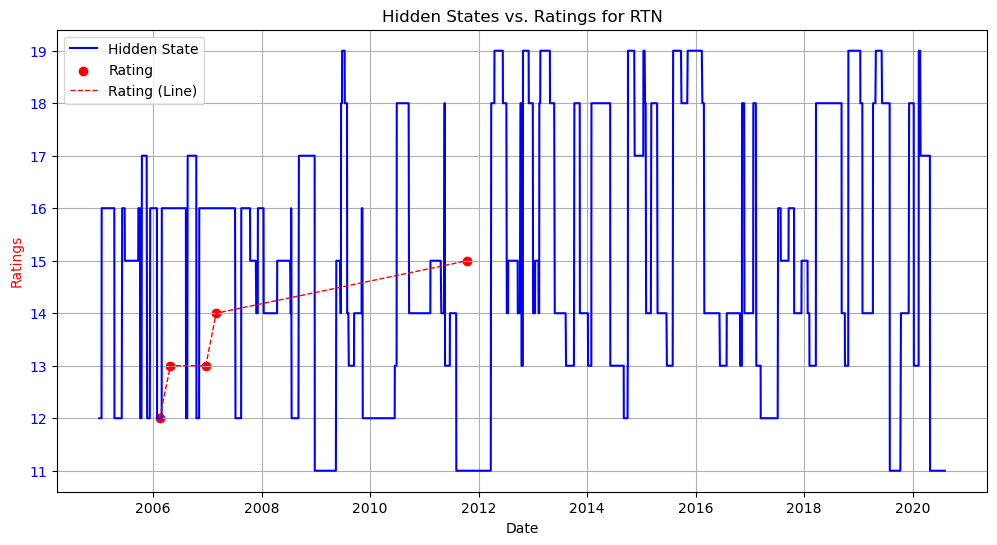

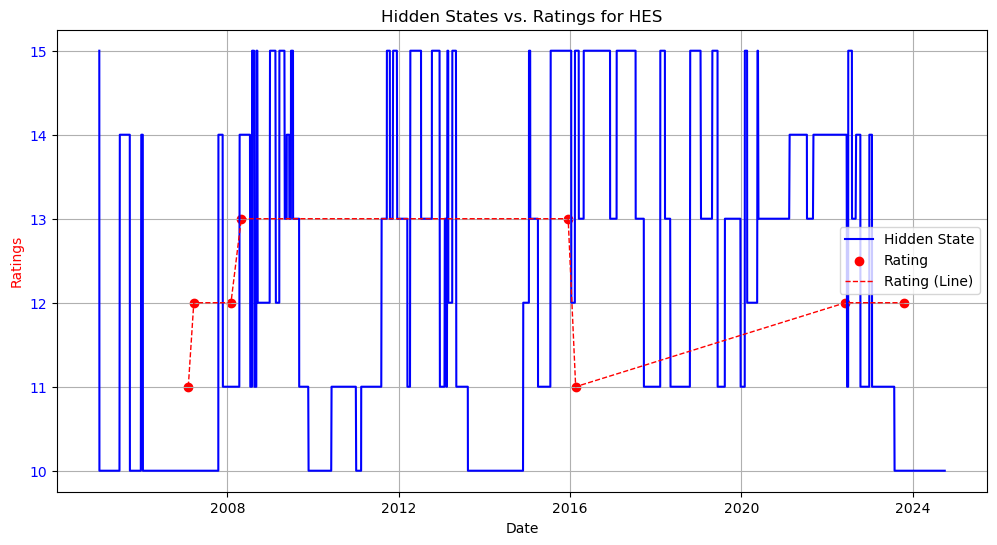

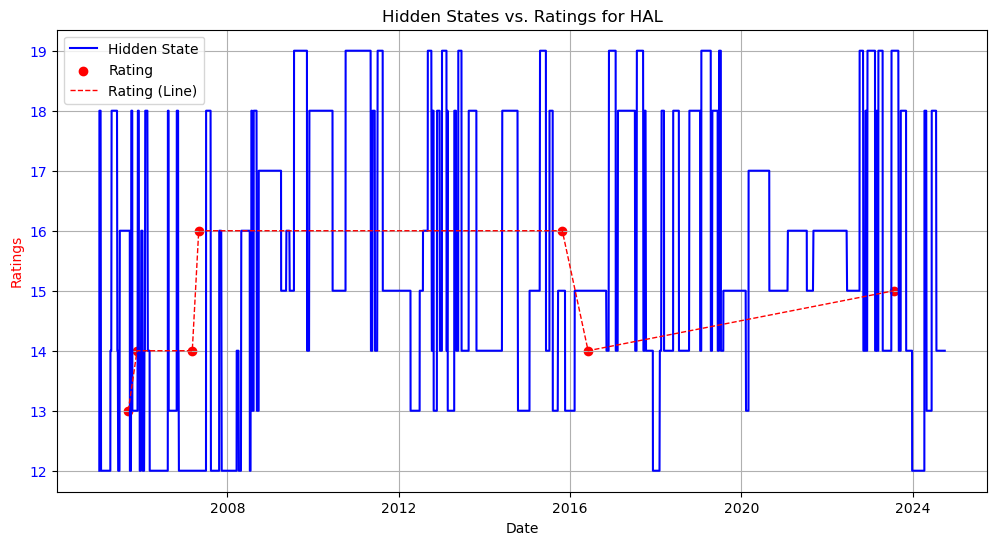

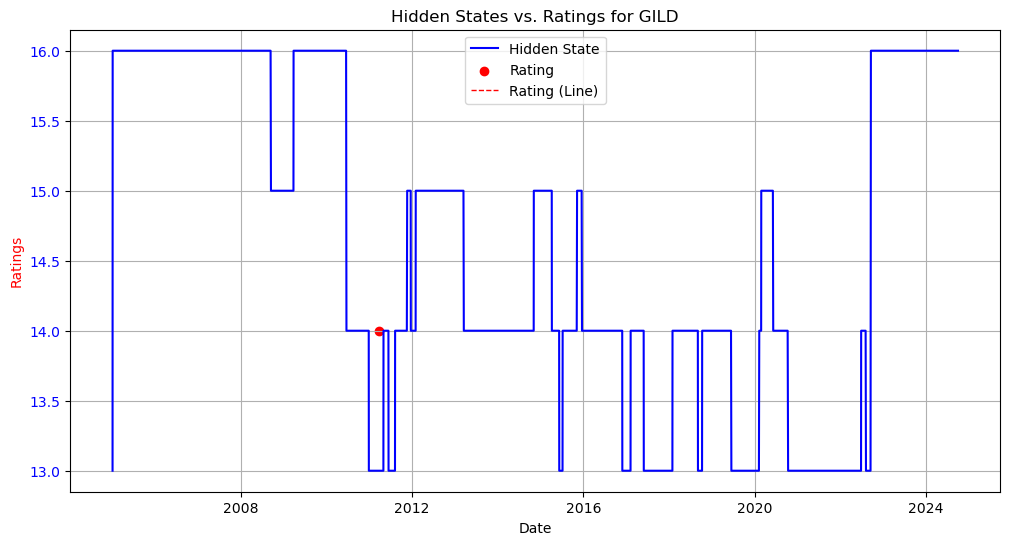

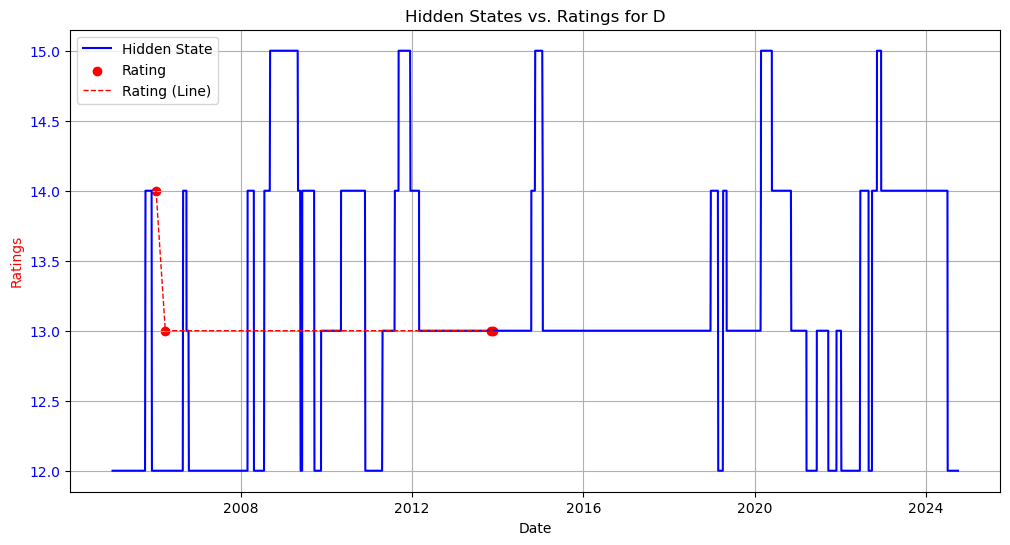

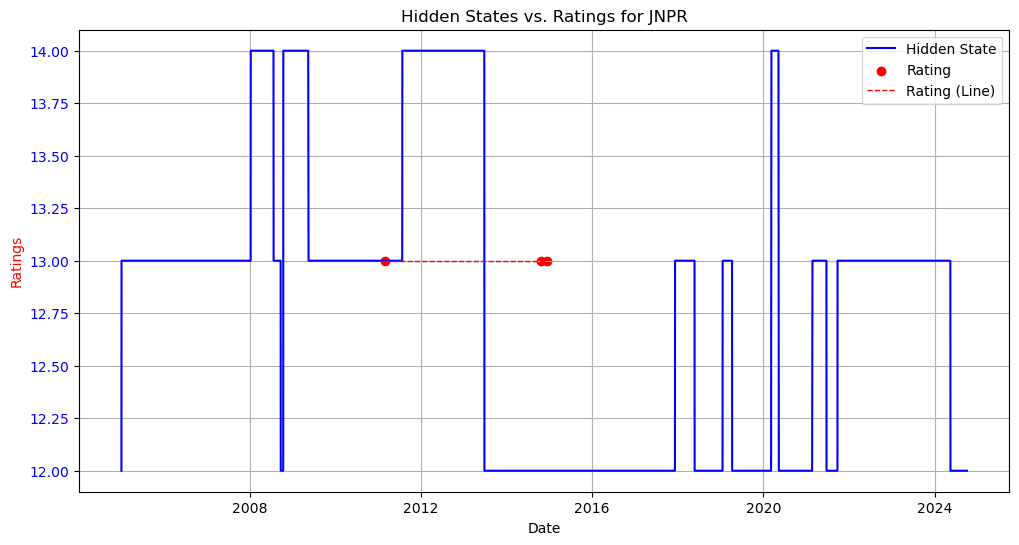

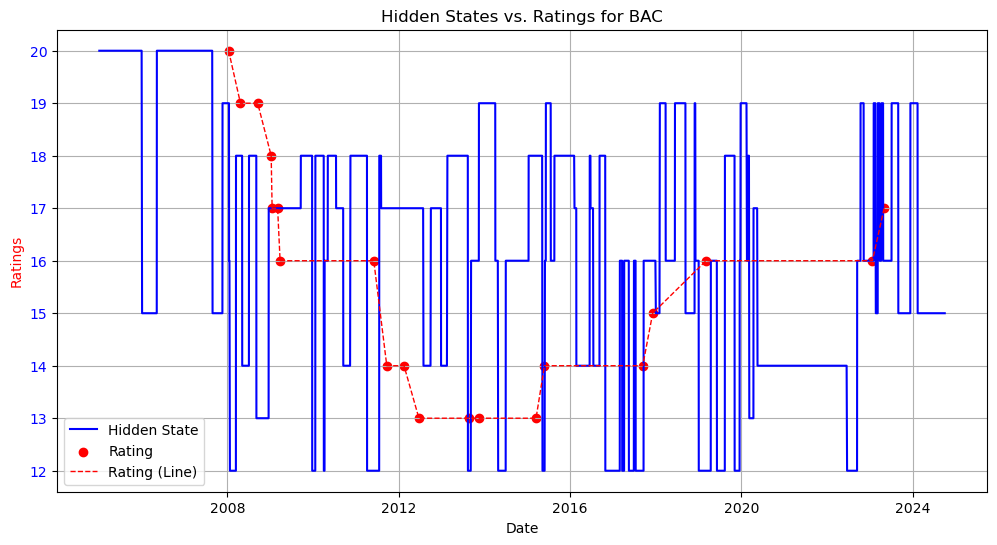

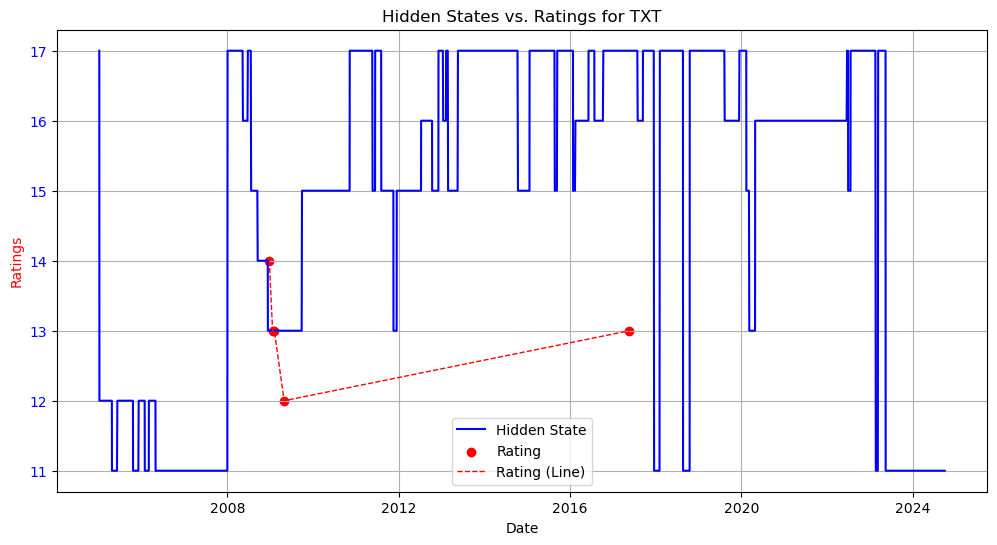

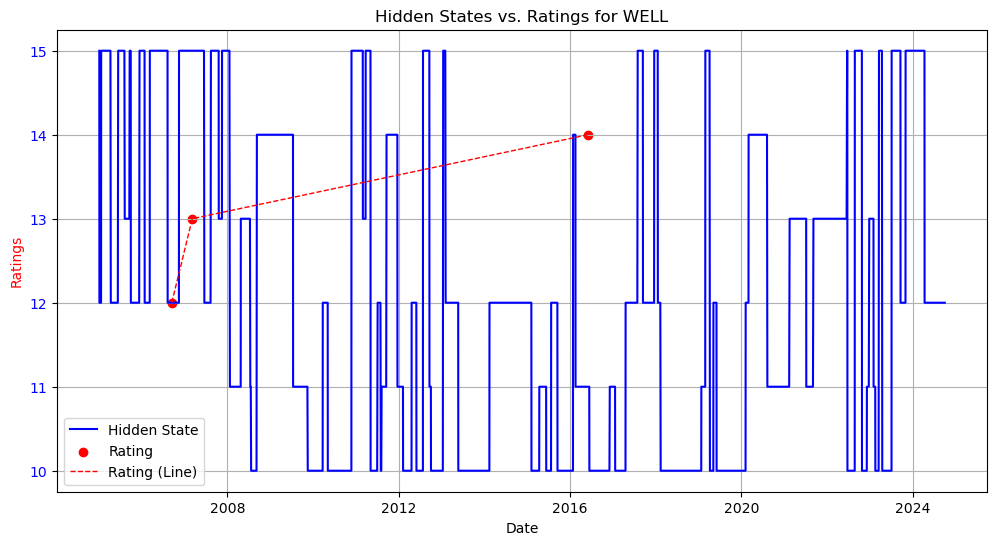

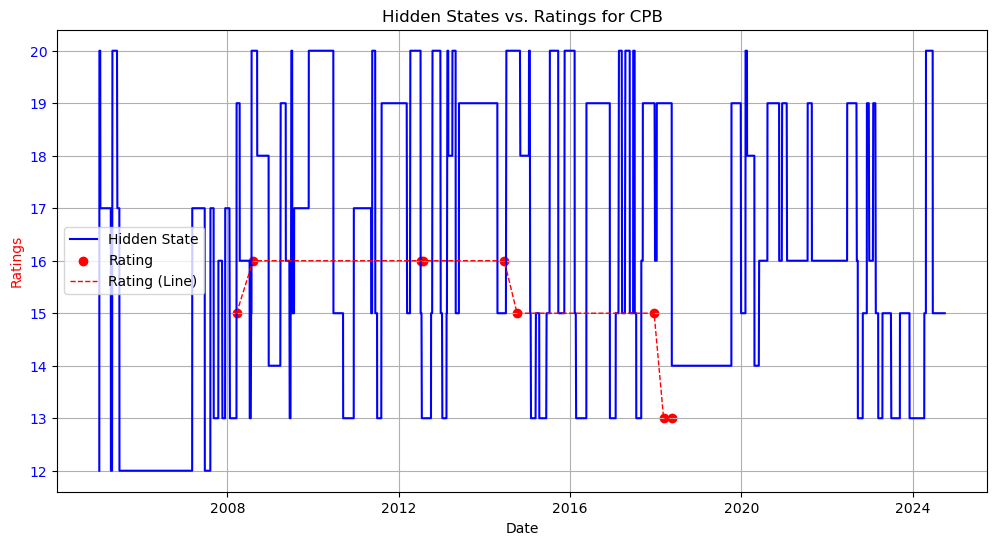

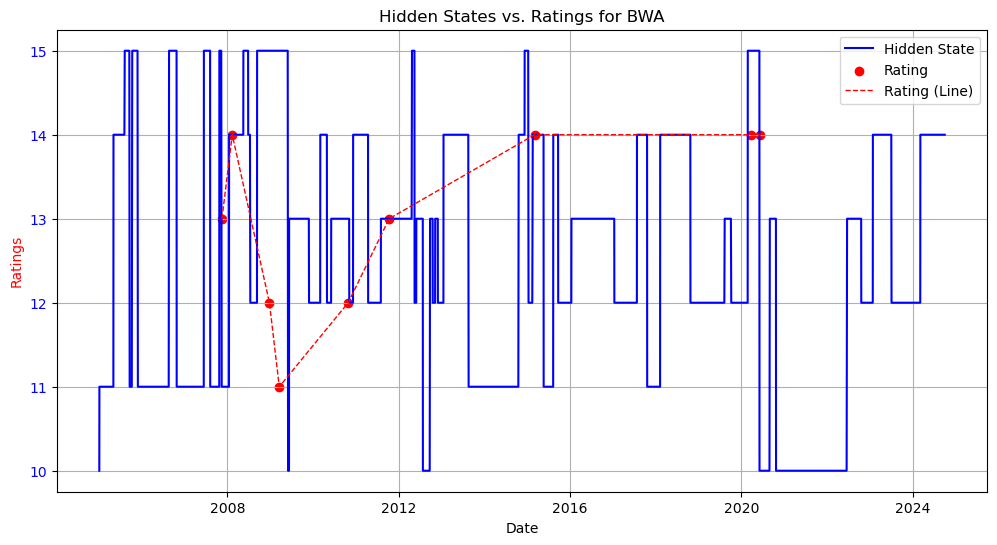

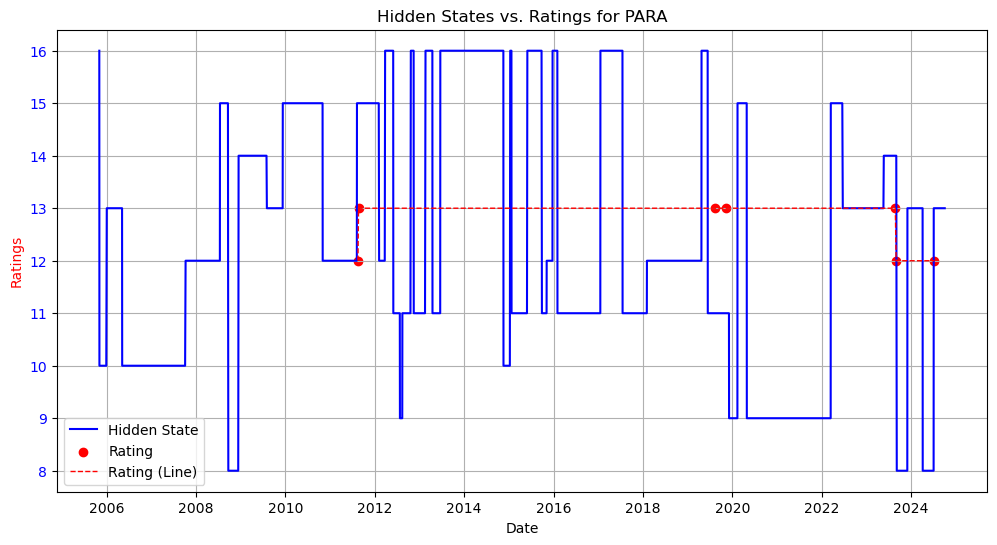

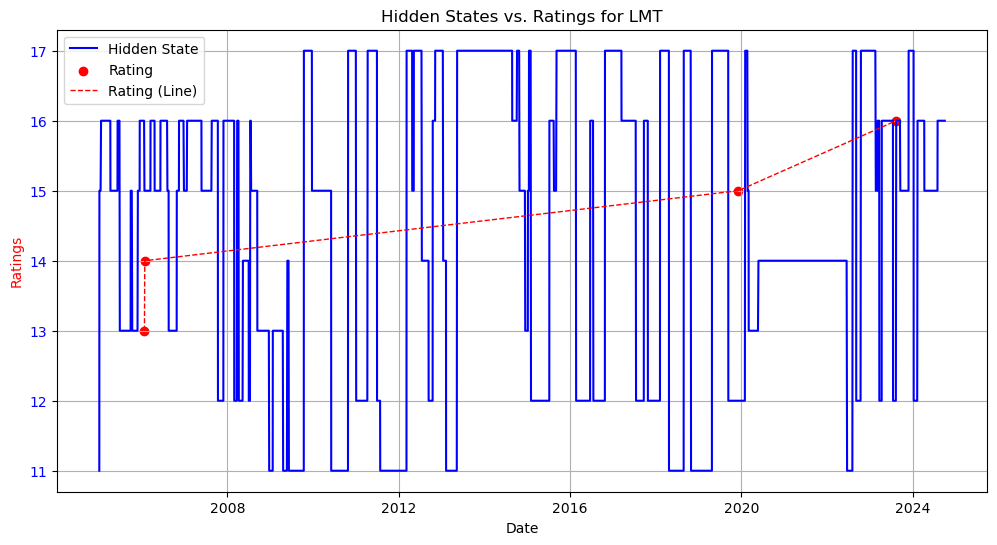

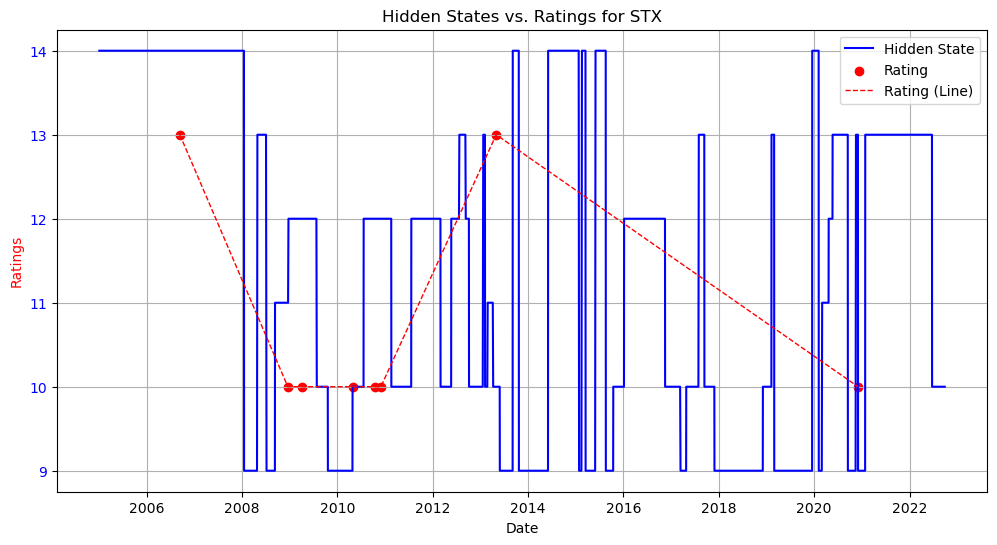

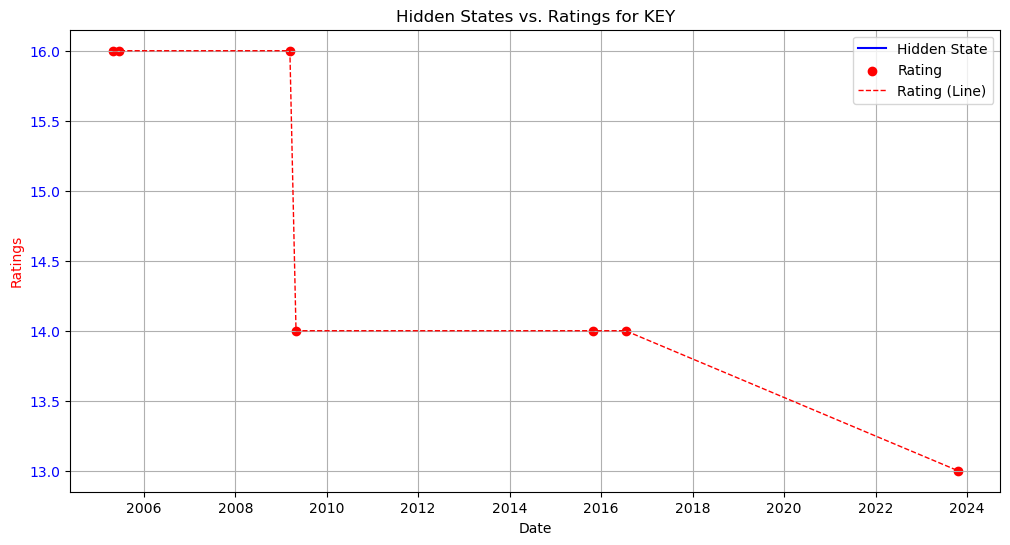

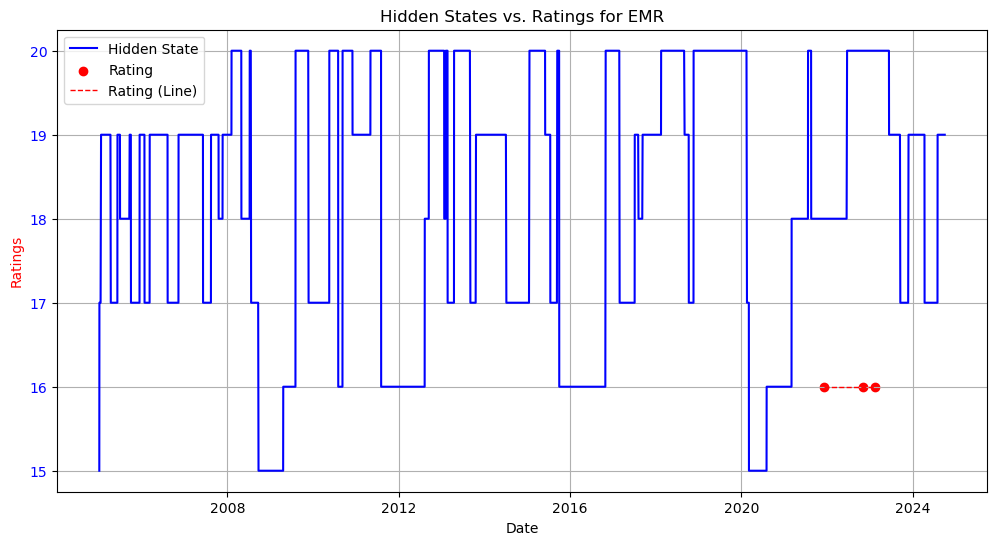

In [31]:
for company in merged_df['Company'].unique():
    company_data = merged_df[merged_df['Company'] == company]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot Hidden States
    ax.plot(company_data['Date'], company_data['Hidden_State'], label='Hidden State', color='blue', linestyle='-')
    ax.set_xlabel('Date')
    ax.set_ylabel('Hidden States', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')
    
    # Overlay Historical Ratings as Dots
    final_ratings_data = company_data.dropna(subset=['State'])
    ax.scatter(final_ratings_data['Date'], final_ratings_data['State'], label='Rating', color='red', marker='o')
    ax.plot(final_ratings_data['Date'], final_ratings_data['State'], label='Rating (Line)', color='red', linestyle='--', linewidth=1)
    ax.set_ylabel('Ratings', color='red')
    
    # Title and Legend
    plt.title(f'Hidden States vs. Ratings for {company}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
merged_df

Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
0     2005-01-03                    0            0.000004           0.000293   
1     2005-01-04                    0            0.000007           0.000385   
2     2005-01-05                    0            0.000007           0.000376   
3     2005-01-06                    0            0.000007           0.000386   
4     2005-01-07                    0            0.000007           0.000385   
...          ...                  ...                 ...                ...   
77323 2024-09-25                    0            0.000001           0.000109   
77324 2024-09-26                    0            0.000001           0.000114   
77325 2024-09-27                    0            0.000001           0.000114   
77326 2024-09-30                    0            0.000001           0.000114   
77327 2024-10-01                    0            0.000001           0.000113   

      BB_3Y_DEFAULT_PROB BB_4Y_DEFAULT_PROB BB_5Y_DEFAULT_PROB  \
0               0.001383            0.00283           0.004748   
1               0.001675           0.003332           0.005458   
2                0.00165           0.003289           0.005399   
3               0.001679           0.003338           0.005468   
4               0.001676           0.003332           0.005458   
...                  ...                ...                ...   
77323           0.000682           0.001559           0.002885   
77324           0.000704           0.001602           0.002955   
77325           0.000702           0.001601           0.002954   
77326             0.0007           0.001597           0.002946   
77327           0.000697           0.001591           0.002938   

      RSK_BB_IMPLIED_CDS_SPREAD  Rate  Pct_Change  ...  Asset_Volatility  \
0                          21.2  4.23   -0.000219  ...          0.038387   
1                          23.3  4.29   -0.000067  ...          0.041405   
2                          23.1  4.29    0.000084  ...          0.041320   
3                          23.3  4.29    0.000236  ...          0.041527   
4                          23.3  4.29    0.000387  ...          0.041533   
...                         ...   ...         ...  ...               ...   
77323                      34.1  3.79    0.002312  ...          0.171349   
77324                      34.1  3.79    0.002334  ...          0.176407   
77325                      34.1  3.75    0.002355  ...          0.176359   
77326                      34.2  3.81    0.002419  ...          0.177033   
77327                      34.2  3.74    0.002441  ...          0.176719   

       Equity_Value_Model  Distance_to_Default  Default_Probability  Company  \
0             1580.528324             6.579069         2.367010e-11      RTN   
1             1585.103878             6.120249         4.671475e-10      RTN   
2             1586.368939             6.141923         4.076413e-10      RTN   
3             1587.612174             6.119987         4.679154e-10      RTN   
4             1588.833412             6.127841         4.453967e-10      RTN   
...                   ...                  ...                  ...      ...   
77323        28047.497116             5.752129         4.406328e-09      EMR   
77324        28063.788676             5.592901         1.116535e-08      EMR   
77325        28073.833382             5.603080         1.052880e-08      EMR   
77326        28134.684725             5.617992         9.659495e-09      EMR   
77327        28140.977303             5.635938         8.705398e-09      EMR   

       Hidden_State  Normalized_Hidden_State  Curr Rtg  Cleaned Rtg  State  
0              12.0                     0.55       NaN          NaN    NaN  
1              12.0                     0.55       NaN          NaN    NaN  
2              12.0                     0.55       NaN          NaN    NaN  
3              12.0                     0.55       NaN          NaN    NaN  

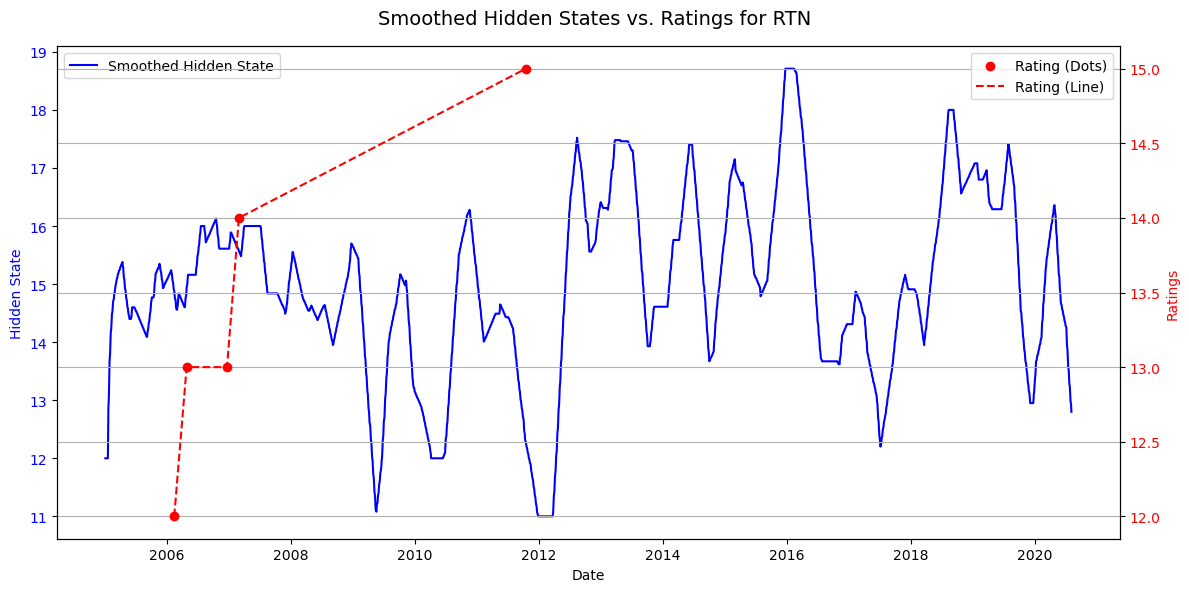

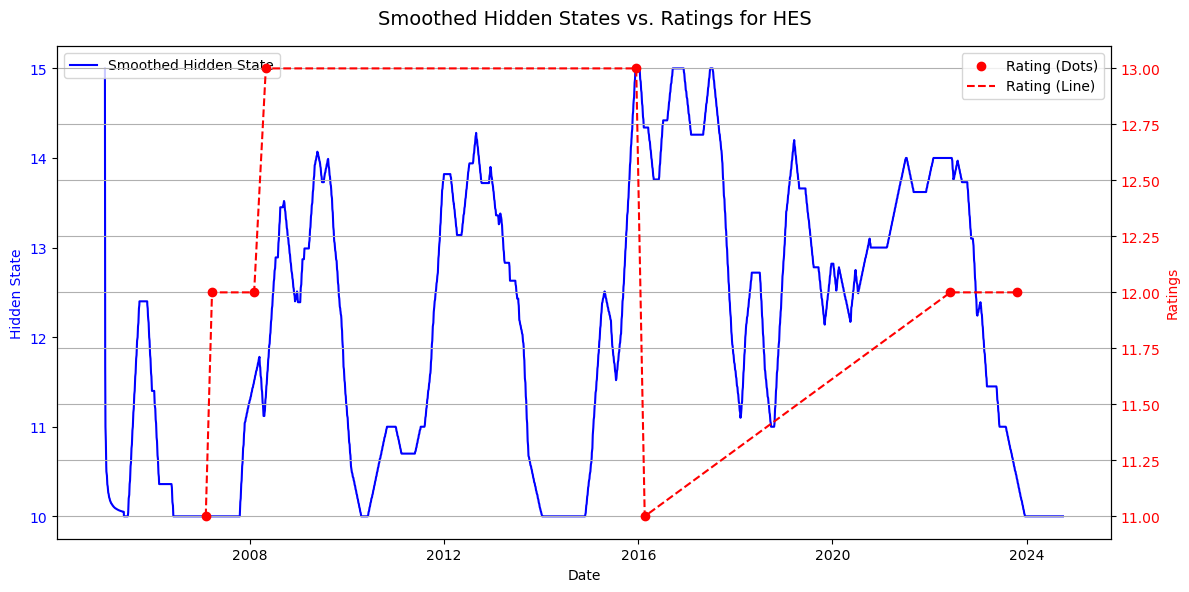

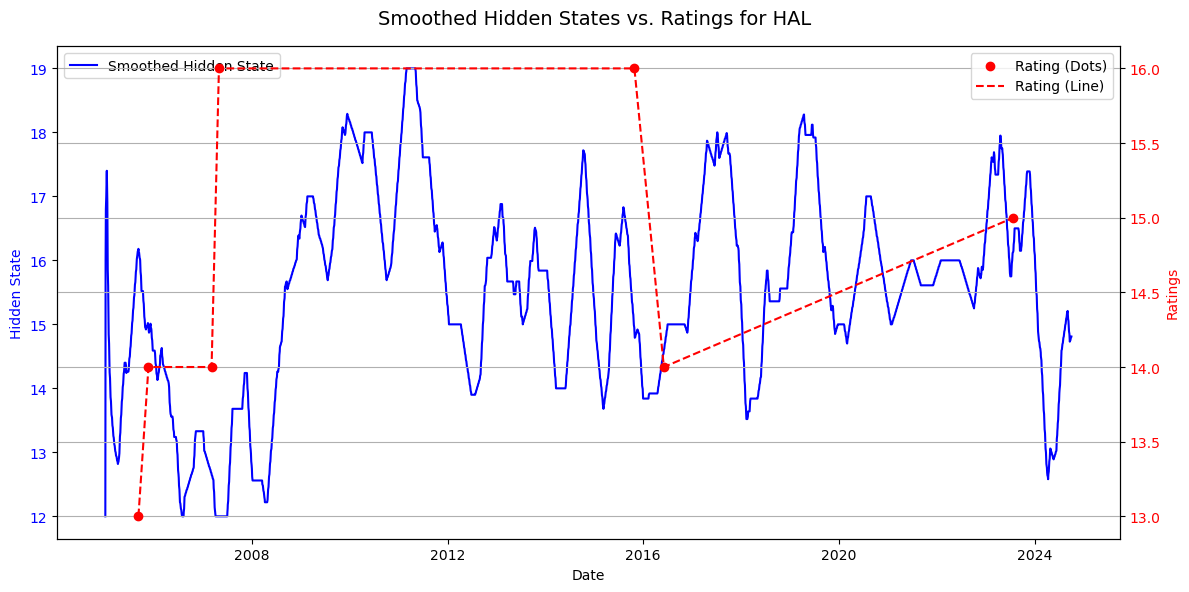

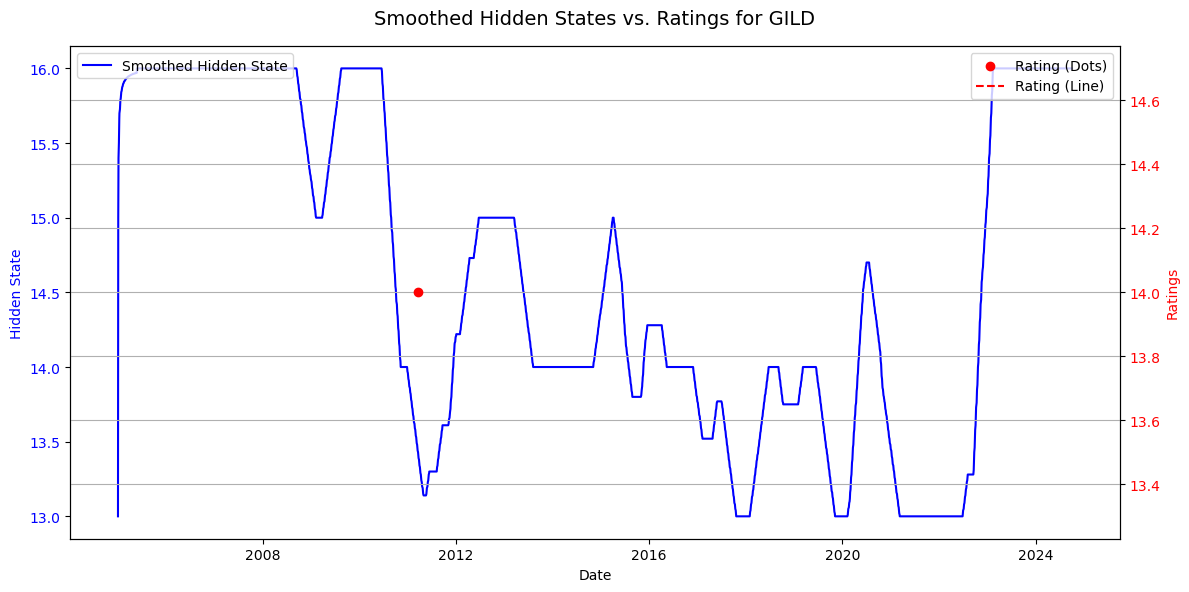

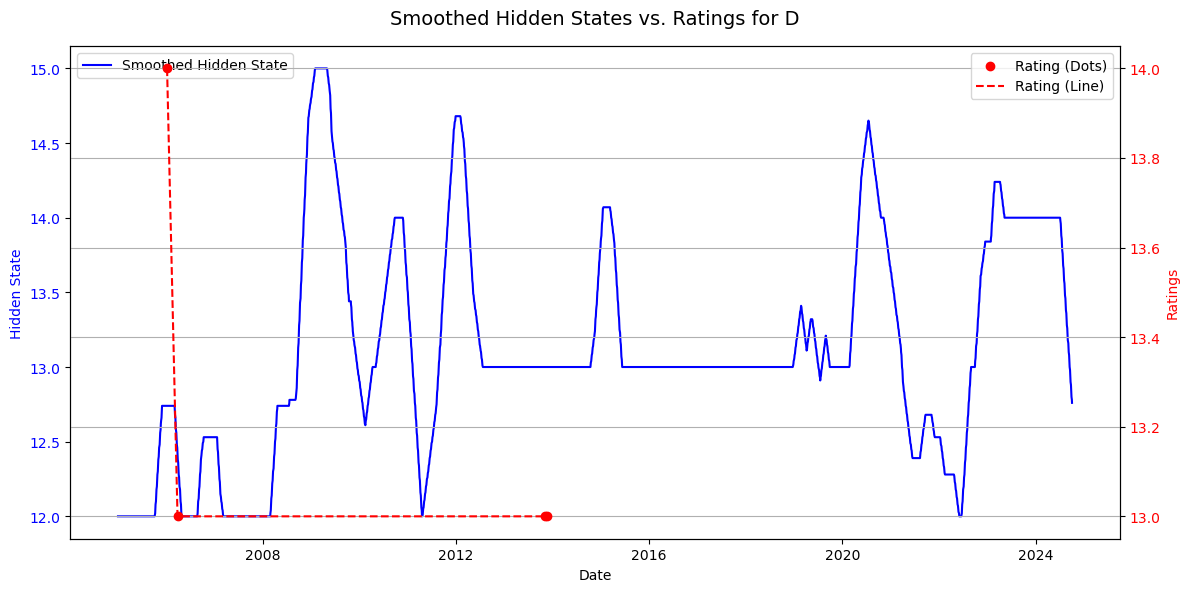

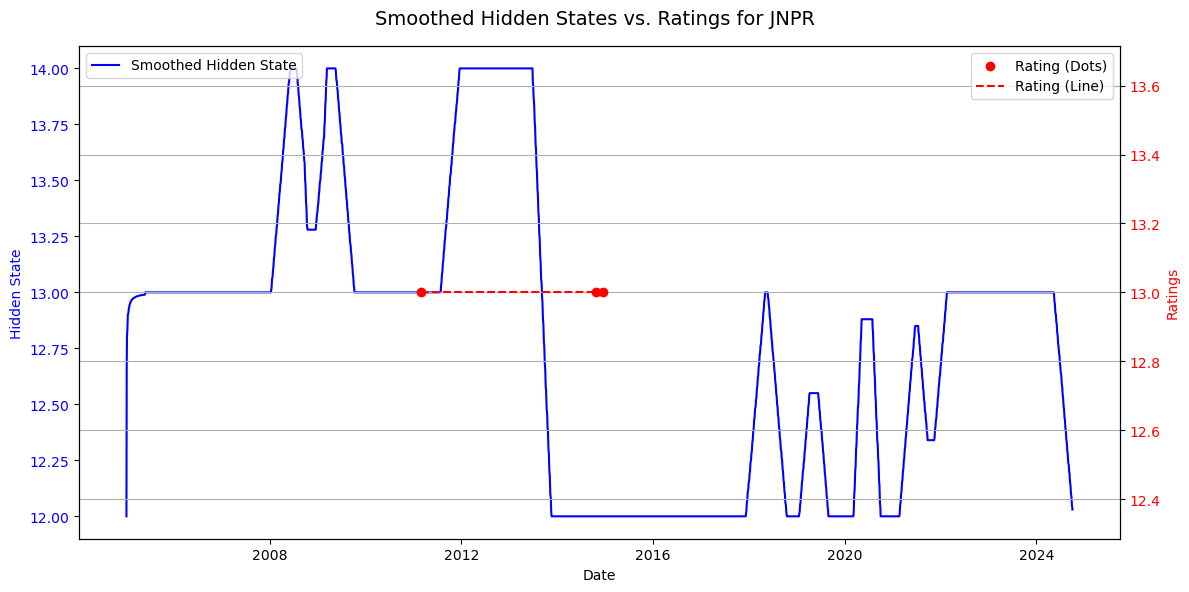

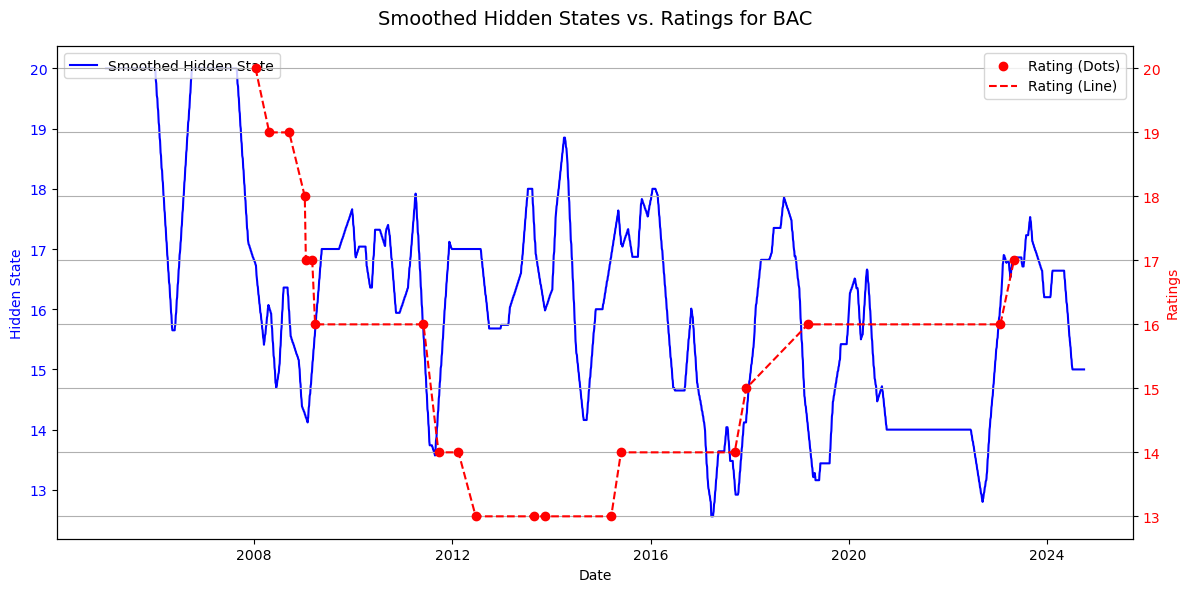

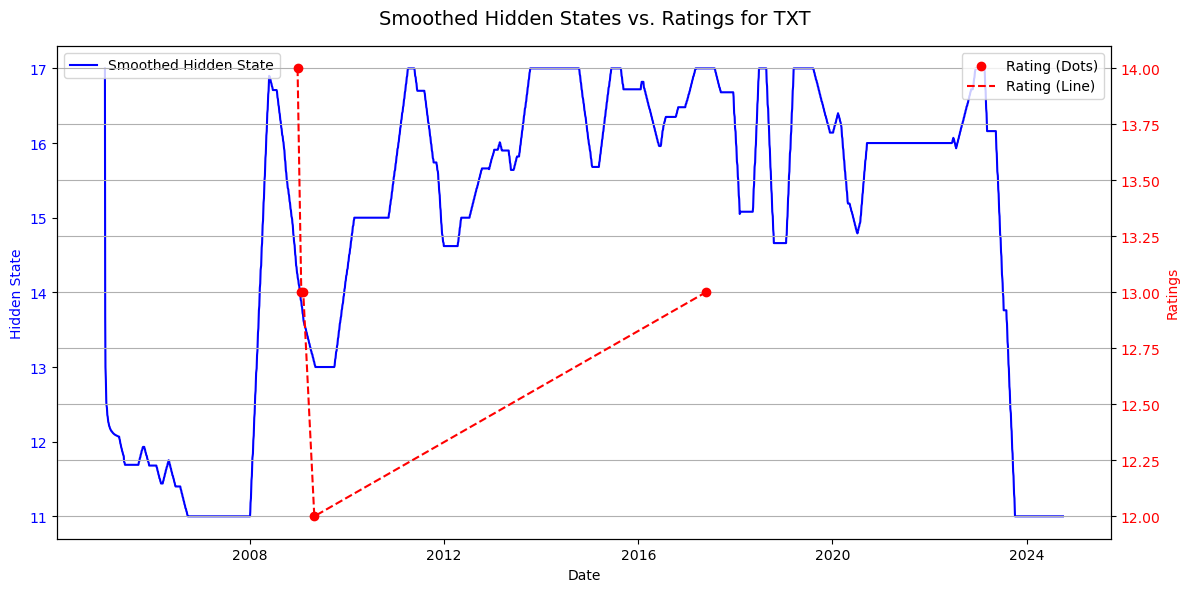

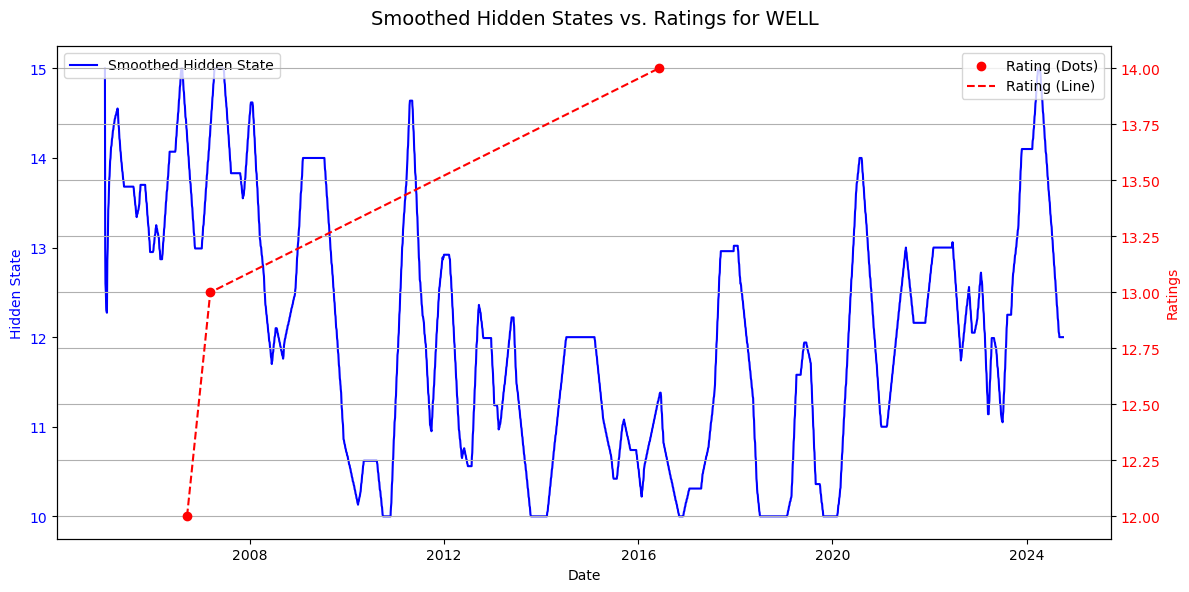

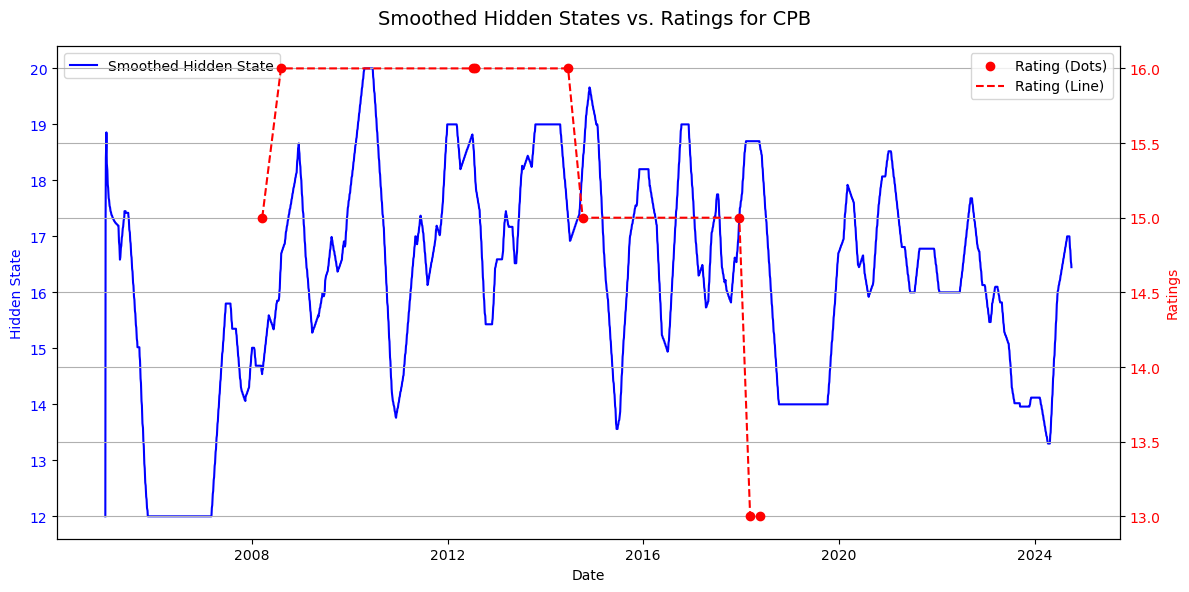

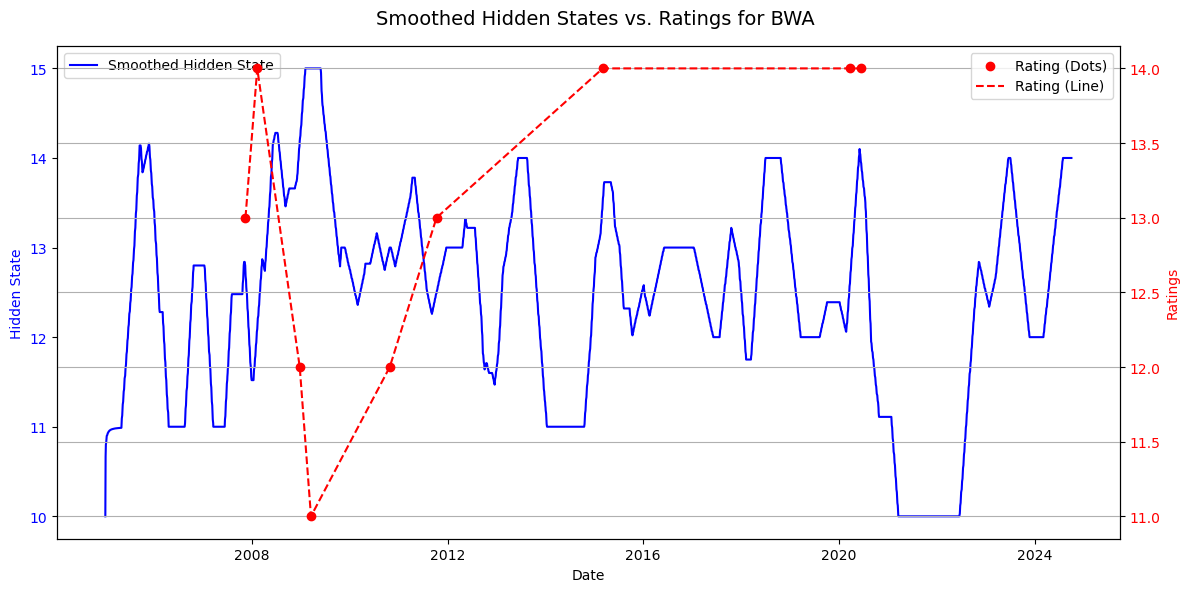

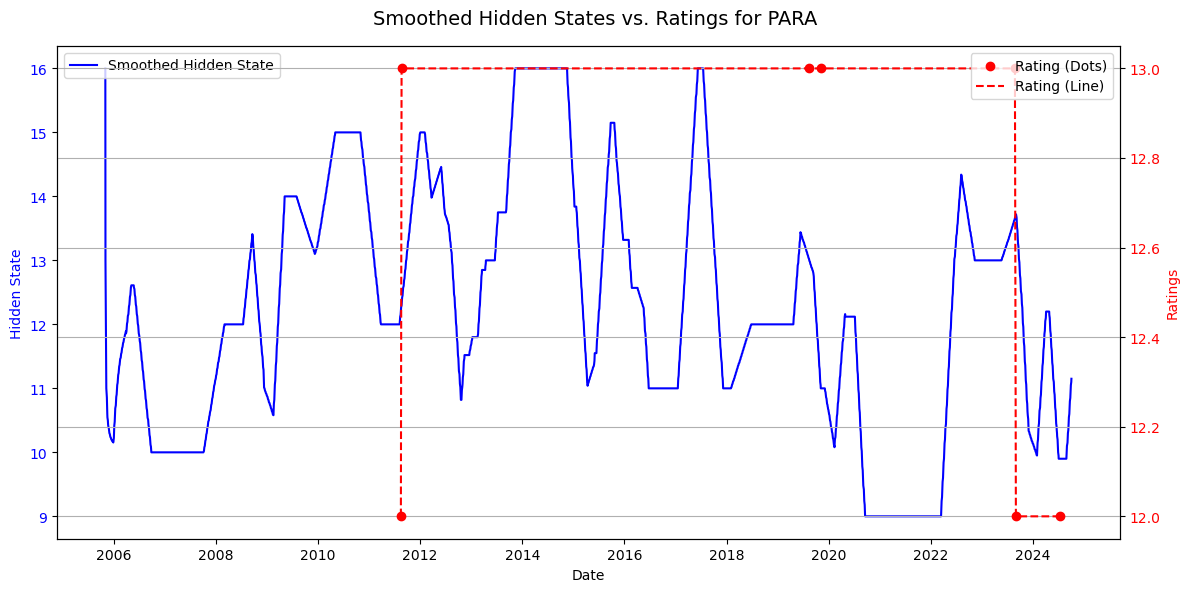

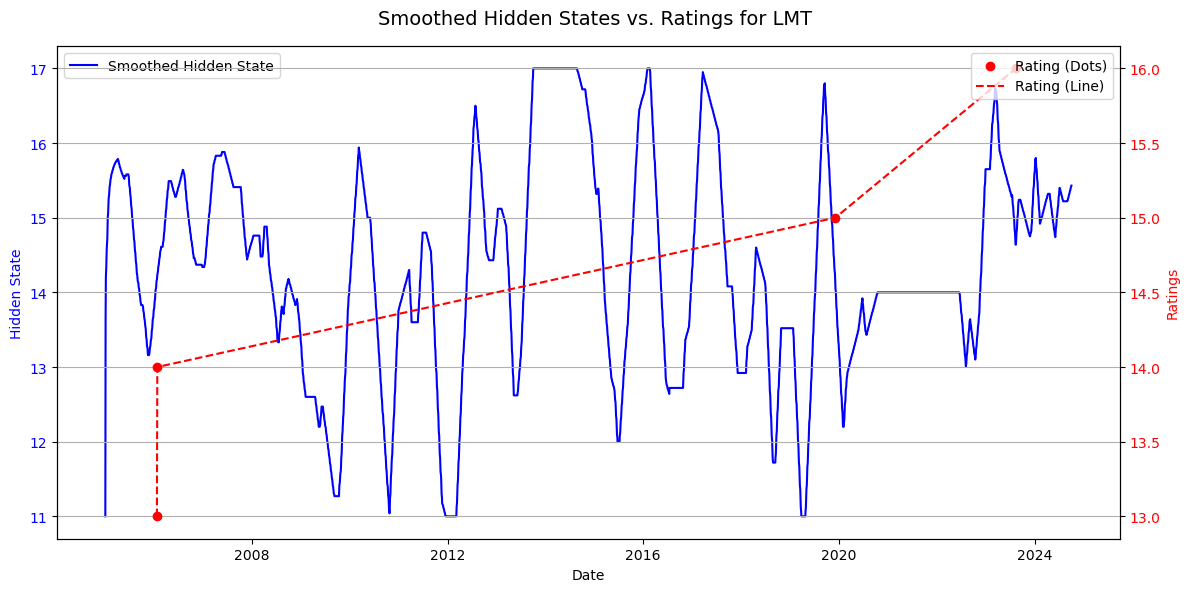

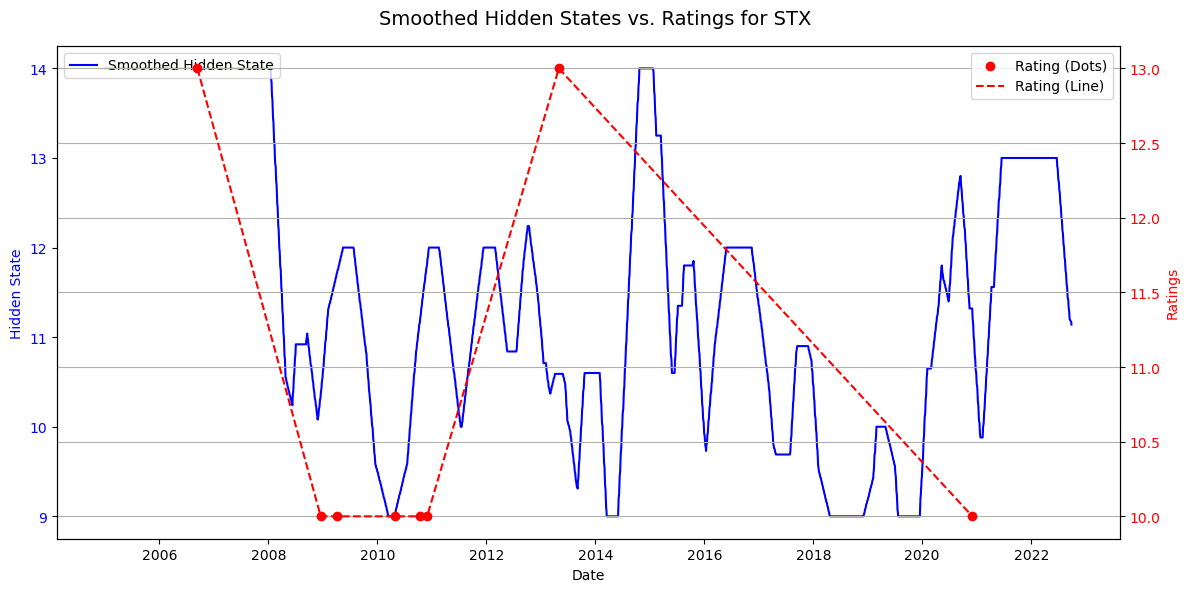

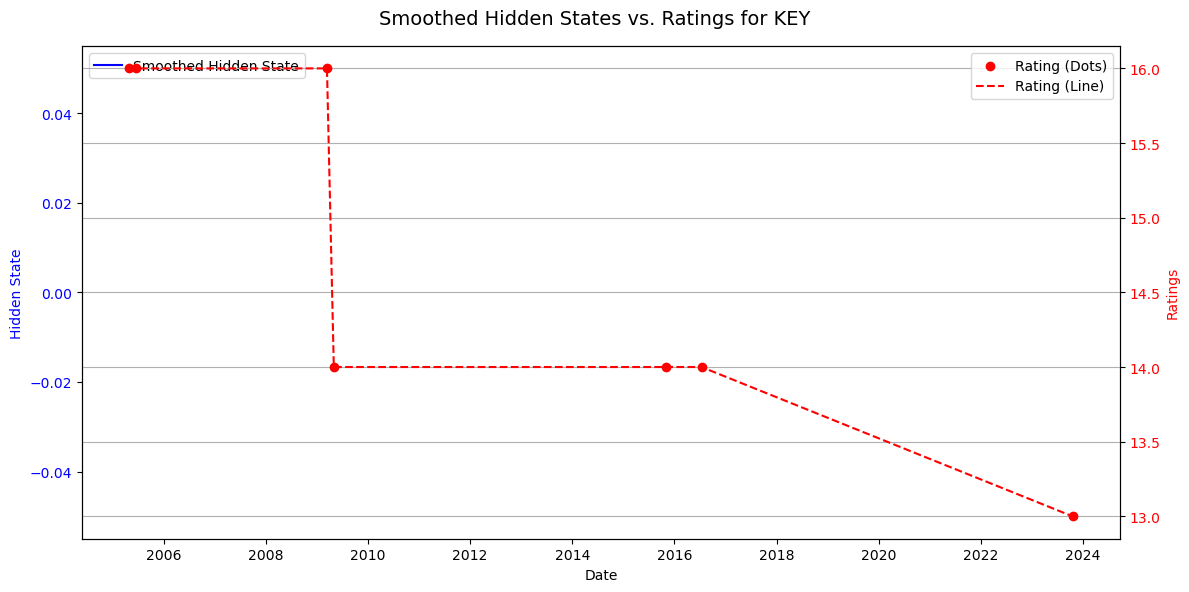

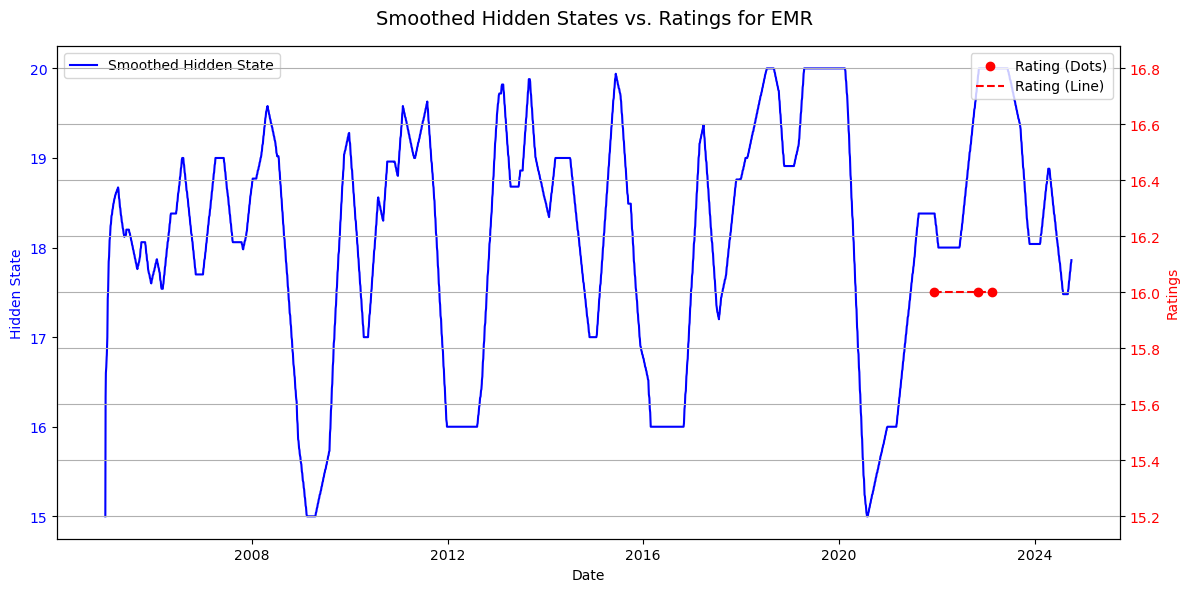

In [72]:
import pandas as pd
import matplotlib.pyplot as plt

# Set a rolling window size (e.g., 30 days)
rolling_window = 100

for company in merged_df['Company'].unique():
    company_data = merged_df[merged_df['Company'] == company].copy()
    ratings_data = company_data.dropna(subset=['State'])

    # Smooth Hidden States using rolling average
    company_data['Smoothed_Hidden_State'] = company_data['Hidden_State'].rolling(window=rolling_window, min_periods=1).mean()

    # Plot Smoothed Hidden States
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(company_data['Date'], company_data['Smoothed_Hidden_State'], label='Smoothed Hidden State', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Hidden State', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Overlay Historical Ratings
    ax2 = ax1.twinx()
    ax2.scatter(ratings_data['Date'], ratings_data['State'], label='Rating (Dots)', color='red', zorder=5)
    ax2.plot(ratings_data['Date'], ratings_data['State'], label='Rating (Line)', color='red', linestyle='--')
    ax2.set_ylabel('Ratings', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and Legend
    fig.suptitle(f'Smoothed Hidden States vs. Ratings for {company}', fontsize=14)
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()


In [92]:
from tensorflow.keras import layers, Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Layer

from tensorflow.keras import backend as K
from tensorflow.keras import Model, layers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

from tensorflow.keras import layers, Model, backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Custom Sampling Layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Custom Loss Layer
class VAE_LossLayer(layers.Layer):
    def call(self, inputs):
        inputs, reconstructed, z_mean, z_log_var = inputs
        reconstruction_loss = tf.reduce_sum(
            tf.square(inputs - reconstructed), axis=1
        )
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1
        )
        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return reconstructed

# VAE Model Builder
def build_vae(input_dim, latent_dim):
    # Encoder
    inputs = layers.Input(shape=(input_dim,))
    x = layers.Dense(64, activation="relu")(inputs)
    x = layers.Dense(32, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    # Decoder
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation="relu")(latent_inputs)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(input_dim, activation="linear")(x)
    decoder = Model(latent_inputs, outputs, name="decoder")

    # VAE Model
    reconstructed = decoder(encoder(inputs)[2])
    vae_loss_layer = VAE_LossLayer()([inputs, reconstructed, z_mean, z_log_var])
    vae = Model(inputs, vae_loss_layer, name="vae")
    vae.compile(optimizer=Adam())

    return vae, encoder, decoder


latent_dim = 2
input_dim = normalized_company_data[list(normalized_company_data.keys())[0]].shape[1]
vae, encoder, decoder = build_vae(input_dim, latent_dim)

# Prepare data and train VAE
vae_hidden_states = {}
for company, data in normalized_company_data.items():
    print(f"Training VAE for {company}...")
    vae.fit(data, data, epochs=50, batch_size=32, verbose=1)
    z_mean, _, _ = encoder.predict(data)
    vae_hidden_states[company] = z_mean

# Add Hidden States to Dataset
for company, hidden_states in vae_hidden_states.items():
    company_indices = HMM_DATA[HMM_DATA['Company'] == company].index
    HMM_DATA.loc[company_indices, 'VAE_Hidden_State_1'] = hidden_states[:, 0]
    HMM_DATA.loc[company_indices, 'VAE_Hidden_State_2'] = hidden_states[:, 1]

# Save updated dataset
HMM_DATA


Training VAE for RTN...
Epoch 1/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 1.8689
Epoch 2/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8119
Epoch 3/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7252
Epoch 4/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5974
Epoch 5/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5778
Epoch 6/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5184
Epoch 7/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4885
Epoch 8/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4695
Epoch 9/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5090
Epoch 10/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5084
Epoch 11/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5032
Epoch 12/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4870
Epoch 13/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.5019
Epoch 14/50
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.4247
Epoch 15/50
122/122 ━━━━━━━━━━━━━

C:\Users\shwet\AppData\Local\Temp\ipykernel_20972\2627747103.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMM_DATA.loc[company_indices, 'VAE_Hidden_State_1'] = hidden_states[:, 0]
C:\Users\shwet\AppData\Local\Temp\ipykernel_20972\2627747103.py:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMM_DATA.loc[company_indices, 'VAE_Hidden_State_2'] = hidden_states[:, 1]


Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
0     2005-01-03                    0            0.000004           0.000293   
1     2005-01-04                    0            0.000007           0.000385   
2     2005-01-05                    0            0.000007           0.000376   
3     2005-01-06                    0            0.000007           0.000386   
4     2005-01-07                    0            0.000007           0.000385   
...          ...                  ...                 ...                ...   
78872 2024-09-25                    0            0.000001           0.000109   
78873 2024-09-26                    0            0.000001           0.000114   
78874 2024-09-27                    0            0.000001           0.000114   
78875 2024-09-30                    0            0.000001           0.000114   
78876 2024-10-01                    0            0.000001           0.000113   

      BB_3Y_DEFAULT_PROB BB_4Y_DEFAULT_PROB BB_5Y_DEFAULT_PROB  \
0               0.001383            0.00283           0.004748   
1               0.001675           0.003332           0.005458   
2                0.00165           0.003289           0.005399   
3               0.001679           0.003338           0.005468   
4               0.001676           0.003332           0.005458   
...                  ...                ...                ...   
78872           0.000682           0.001559           0.002885   
78873           0.000704           0.001602           0.002955   
78874           0.000702           0.001601           0.002954   
78875             0.0007           0.001597           0.002946   
78876           0.000697           0.001591           0.002938   

      RSK_BB_IMPLIED_CDS_SPREAD  Rate  Pct_Change  ...   Asset_Value  \
0                          21.2  4.23   -0.000219  ...   7063.568086   
1                          23.3  4.29   -0.000067  ...   7060.117029   
2                          23.1  4.29    0.000084  ...   7056.679104   
3                          23.3  4.29    0.000236  ...   7053.254316   
4                          23.3  4.29    0.000387  ...   7049.842671   
...                         ...   ...         ...  ...           ...   
78872                      34.1  3.79    0.002312  ...  44362.629496   
78873                      34.1  3.79    0.002334  ...  44339.861742   
78874                      34.1  3.75    0.002355  ...  44316.817415   
78875                      34.2  3.81    0.002419  ...  44246.000000   
78876                      34.2  3.74    0.002441  ...  44221.824383   

       Asset_Volatility  Equity_Value_Model  Distance_to_Default  \
0              0.038387         1580.528324             6.579069   
1              0.041405         1585.103878             6.120249   
2              0.041320         1586.368939             6.141923   
3              0.041527         1587.612174             6.119987   
4              0.041533         1588.833412             6.127841   
...                 ...                 ...                  ...   
78872          0.171349        28047.497116             5.752129   
78873          0.176407        28063.788676             5.592901   
78874          0.176359        28073.833382             5.603080   
78875          0.177033        28134.684725             5.617992   
78876          0.176719        28140.977303             5.635938   

       Default_Probability  Company  Hidden_State  Normalized_Hidden_State  \
0             2.367010e-11      RTN          12.0                     0.55   
1             4.671475e-10      RTN          12.0                     0.55   
2             4.076413e-10      RTN          12.0                     0.55   
3             4.679154e-10      RTN          12.0                     0.55   
4             4.453967e-10      RTN          12.0                     0.55   
...                    ...      ...           ...                      ...   
78872         4.406328e-09    

In [100]:
def normalize_to_rating_scale(value, min_rating=1, max_rating=21):
    return min_rating + (value - value.min()) / (value.max() - value.min()) * (max_rating - min_rating)

# Add normalized hidden states for mapping
HMM_DATA['Normalized_VAE_Hidden_State_1'] = normalize_to_rating_scale(HMM_DATA['VAE_Hidden_State_1'])
HMM_DATA['Normalized_VAE_Hidden_State_2'] = normalize_to_rating_scale(HMM_DATA['VAE_Hidden_State_2'])

# Combine normalized hidden states (use the average as a single metric)
HMM_DATA['Combined_VAE_Hidden_State'] = (
    HMM_DATA['Normalized_VAE_Hidden_State_1'] + HMM_DATA['Normalized_VAE_Hidden_State_2']
) / 2

# Map to ratings using valid ranges (Min_State and Max_State)
def map_to_rating(hidden_state, min_state, max_state):
    if hidden_state < min_state:
        return min_state
    elif hidden_state > max_state:
        return max_state
    else:
        return round(hidden_state)

# Apply the mapping for each company
for company in HMM_DATA['Company'].unique():
    company_min_state = ratings.loc[ratings['Ticker'] == company, 'Min_State'].values[0]
    company_max_state = ratings.loc[ratings['Ticker'] == company, 'Max_State'].values[0]
    
    HMM_DATA.loc[HMM_DATA['Company'] == company, 'Mapped_Rating'] = HMM_DATA.loc[
        HMM_DATA['Company'] == company, 'Combined_VAE_Hidden_State'
    ].apply(map_to_rating, args=(company_min_state, company_max_state))

# Final mapped ratings
HMM_DATA['Mapped_Rating'] = HMM_DATA['Mapped_Rating'].astype(int)

C:\Users\shwet\AppData\Local\Temp\ipykernel_20972\1927218193.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMM_DATA['Normalized_VAE_Hidden_State_1'] = normalize_to_rating_scale(HMM_DATA['VAE_Hidden_State_1'])
C:\Users\shwet\AppData\Local\Temp\ipykernel_20972\1927218193.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  HMM_DATA['Normalized_VAE_Hidden_State_2'] = normalize_to_rating_scale(HMM_DATA['VAE_Hidden_State_2'])
C:\Users\shwet\AppData\Local\Temp\ipykernel_20972\1927218193.py:9: SettingWithCopy

In [102]:
HMM_DATA

Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
0     2005-01-03                    0            0.000004           0.000293   
1     2005-01-04                    0            0.000007           0.000385   
2     2005-01-05                    0            0.000007           0.000376   
3     2005-01-06                    0            0.000007           0.000386   
4     2005-01-07                    0            0.000007           0.000385   
...          ...                  ...                 ...                ...   
78872 2024-09-25                    0            0.000001           0.000109   
78873 2024-09-26                    0            0.000001           0.000114   
78874 2024-09-27                    0            0.000001           0.000114   
78875 2024-09-30                    0            0.000001           0.000114   
78876 2024-10-01                    0            0.000001           0.000113   

      BB_3Y_DEFAULT_PROB BB_4Y_DEFAULT_PROB BB_5Y_DEFAULT_PROB  \
0               0.001383            0.00283           0.004748   
1               0.001675           0.003332           0.005458   
2                0.00165           0.003289           0.005399   
3               0.001679           0.003338           0.005468   
4               0.001676           0.003332           0.005458   
...                  ...                ...                ...   
78872           0.000682           0.001559           0.002885   
78873           0.000704           0.001602           0.002955   
78874           0.000702           0.001601           0.002954   
78875             0.0007           0.001597           0.002946   
78876           0.000697           0.001591           0.002938   

      RSK_BB_IMPLIED_CDS_SPREAD  Rate  Pct_Change  ...  Default_Probability  \
0                          21.2  4.23   -0.000219  ...         2.367010e-11   
1                          23.3  4.29   -0.000067  ...         4.671475e-10   
2                          23.1  4.29    0.000084  ...         4.076413e-10   
3                          23.3  4.29    0.000236  ...         4.679154e-10   
4                          23.3  4.29    0.000387  ...         4.453967e-10   
...                         ...   ...         ...  ...                  ...   
78872                      34.1  3.79    0.002312  ...         4.406328e-09   
78873                      34.1  3.79    0.002334  ...         1.116535e-08   
78874                      34.1  3.75    0.002355  ...         1.052880e-08   
78875                      34.2  3.81    0.002419  ...         9.659495e-09   
78876                      34.2  3.74    0.002441  ...         8.705398e-09   

       Company  Hidden_State  Normalized_Hidden_State  VAE_Hidden_State_1  \
0          RTN          12.0                     0.55            0.694618   
1          RTN          12.0                     0.55            0.637405   
2          RTN          12.0                     0.55            0.608377   
3          RTN          12.0                     0.55            0.574088   
4          RTN          12.0                     0.55            0.542940   
...        ...           ...                      ...                 ...   
78872      EMR          19.0                     0.90            0.389660   
78873      EMR          19.0                     0.90            0.364595   
78874      EMR          19.0                     0.90            0.353669   
78875      EMR          19.0                     0.90            0.364411   
78876      EMR          19.0                     0.90            0.346851   

       VAE_Hidden_State_2  Normalized_VAE_Hidden_State_1  \
0                0.068331                      12.571875   
1                0.053365                      12.412672   
2                0.082063                      12.331897   
3                0.104774                      12.236479   
4                0.130375                      12.149806   
...                   ..

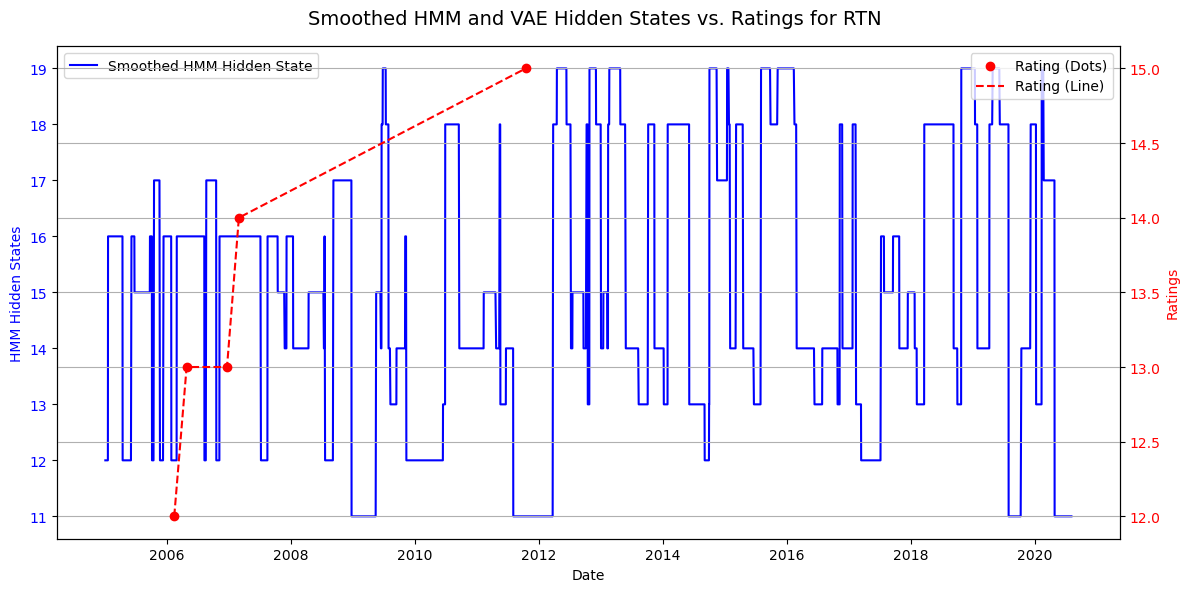

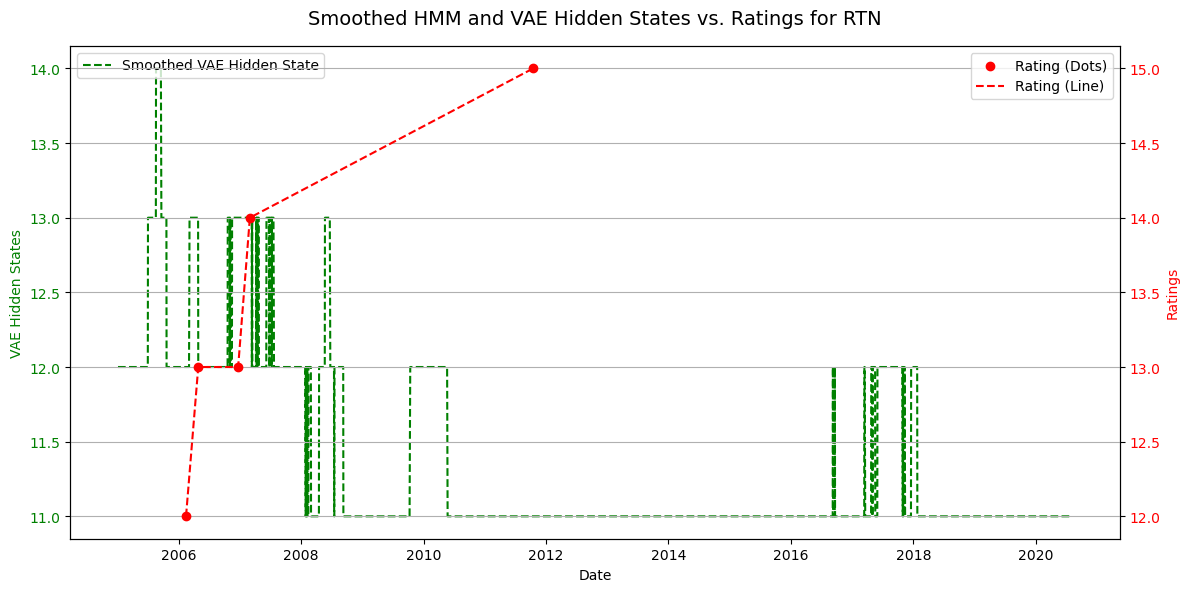

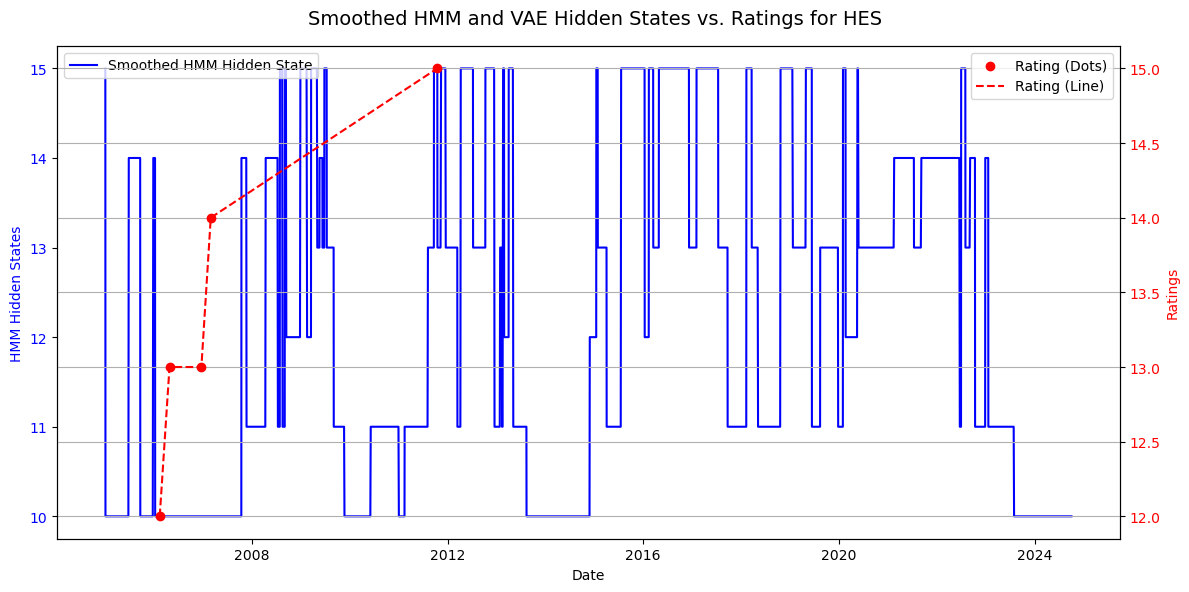

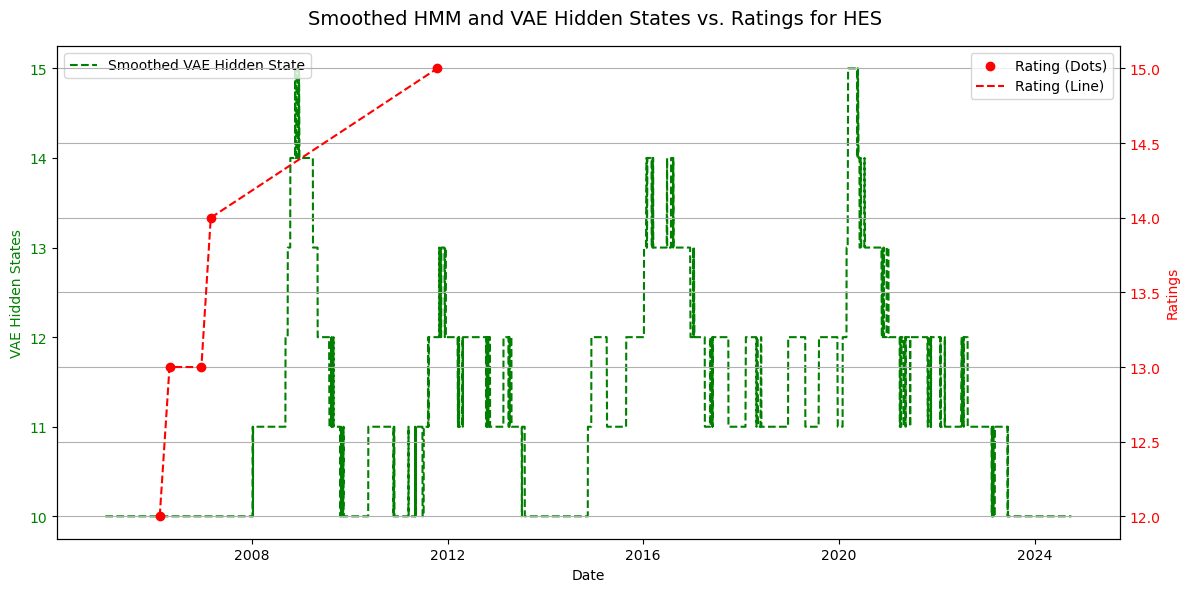

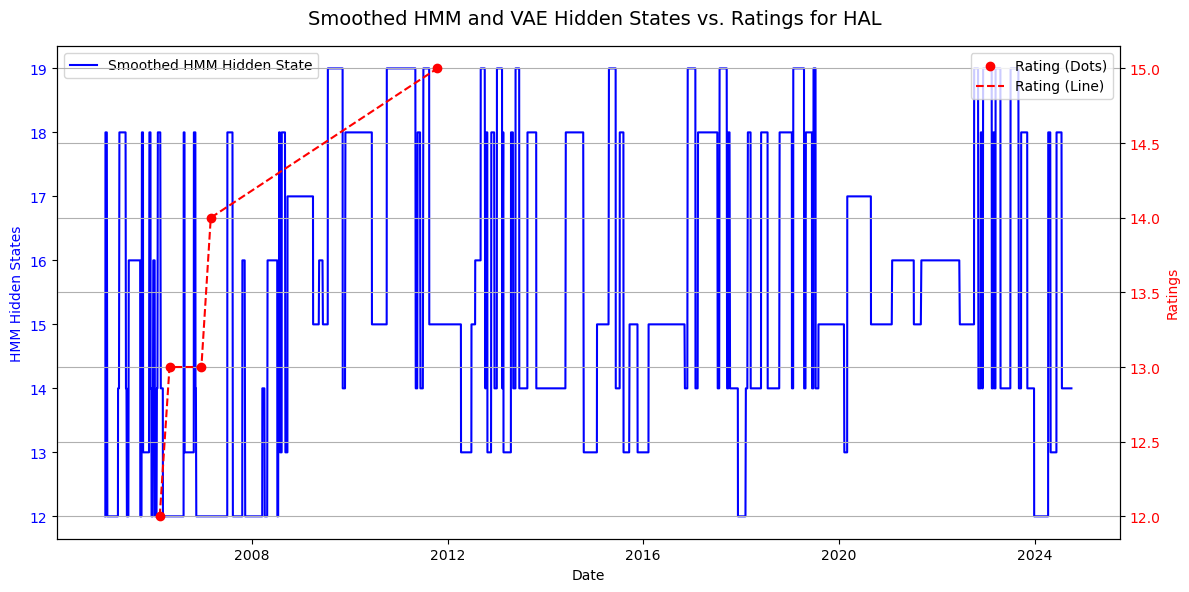

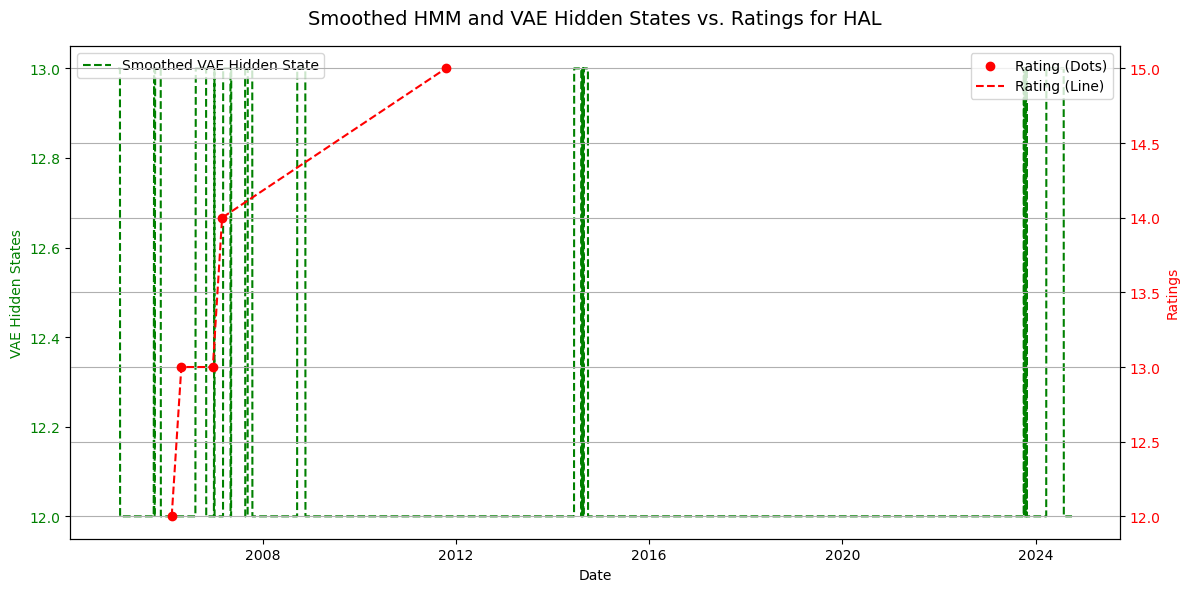

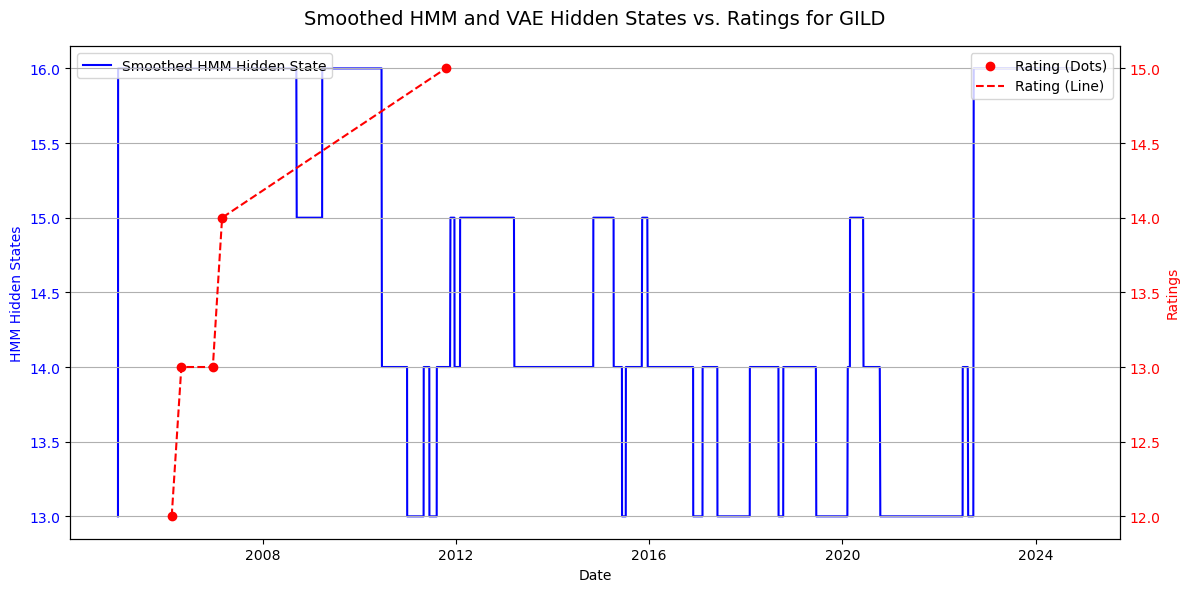

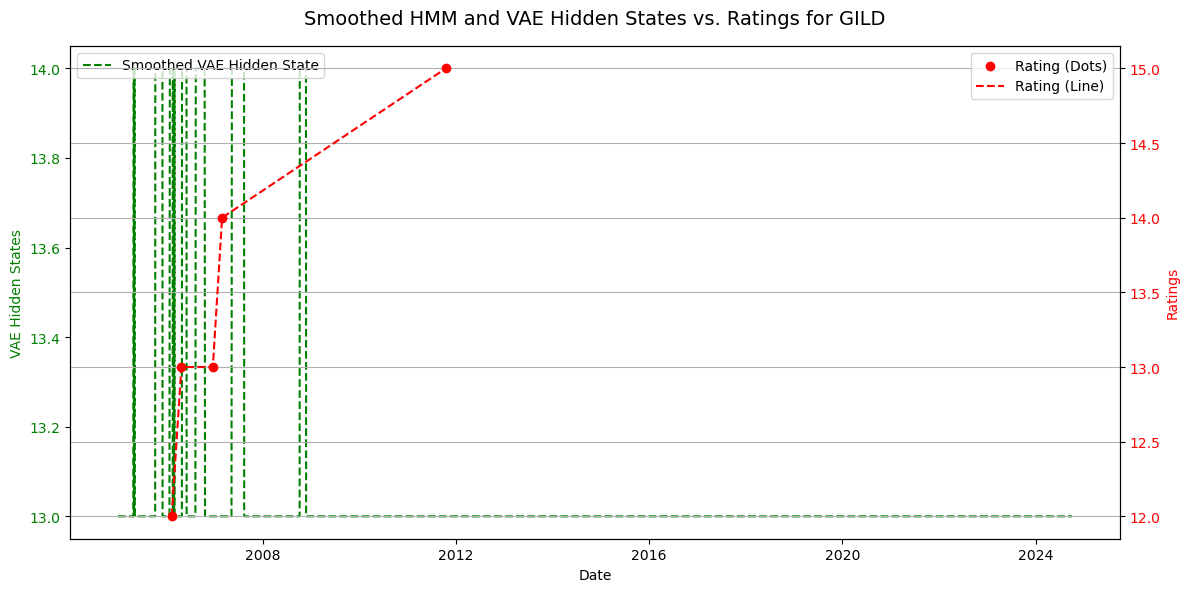

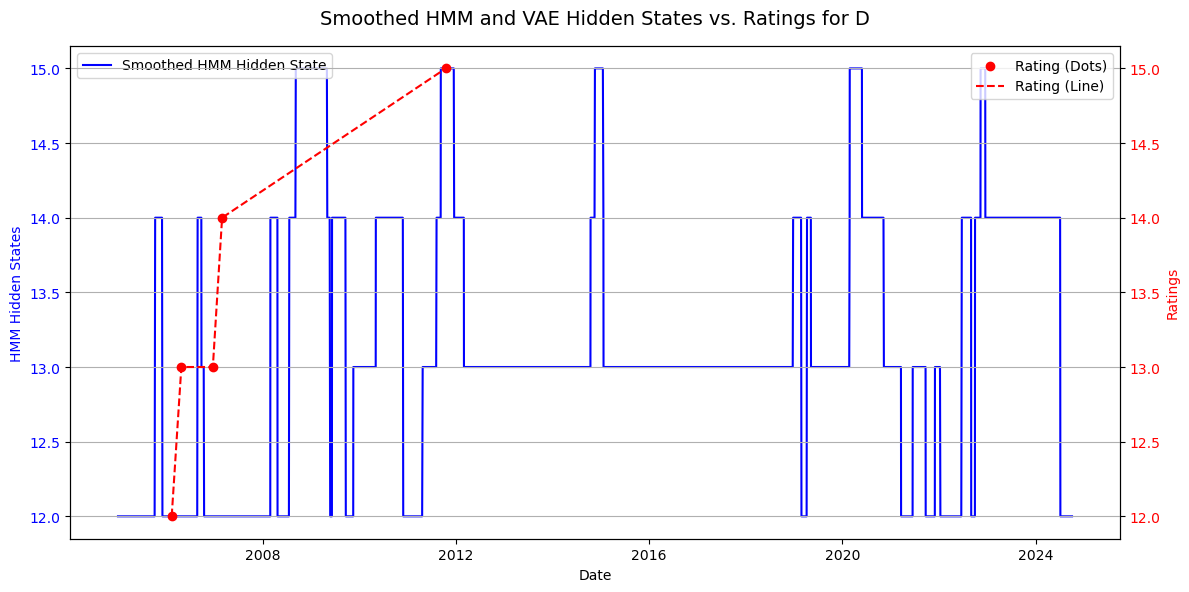

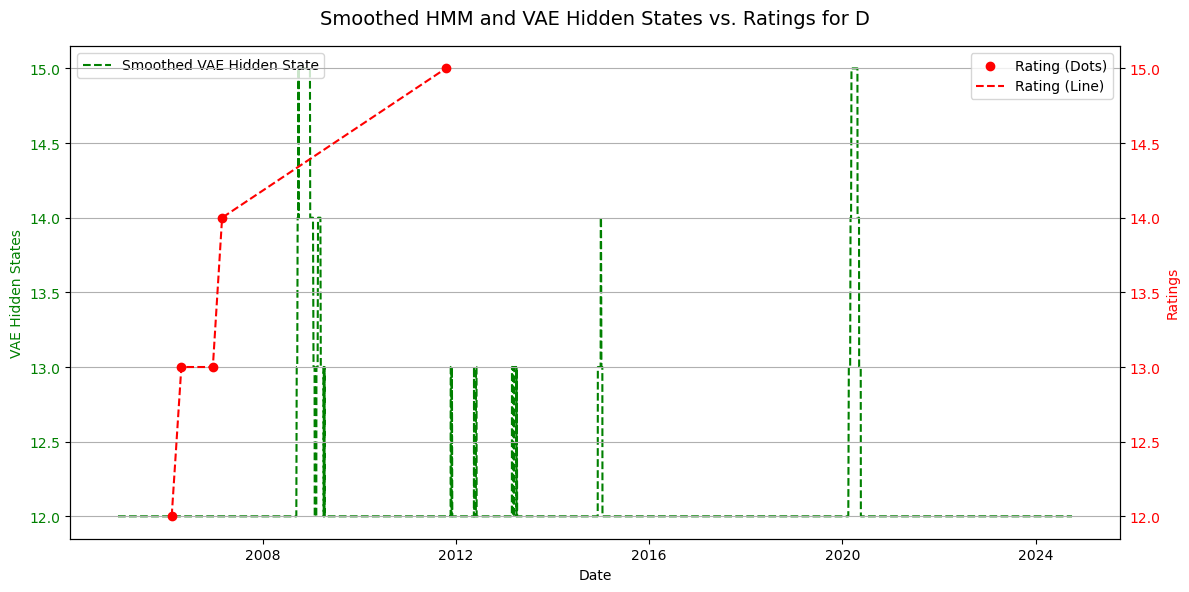

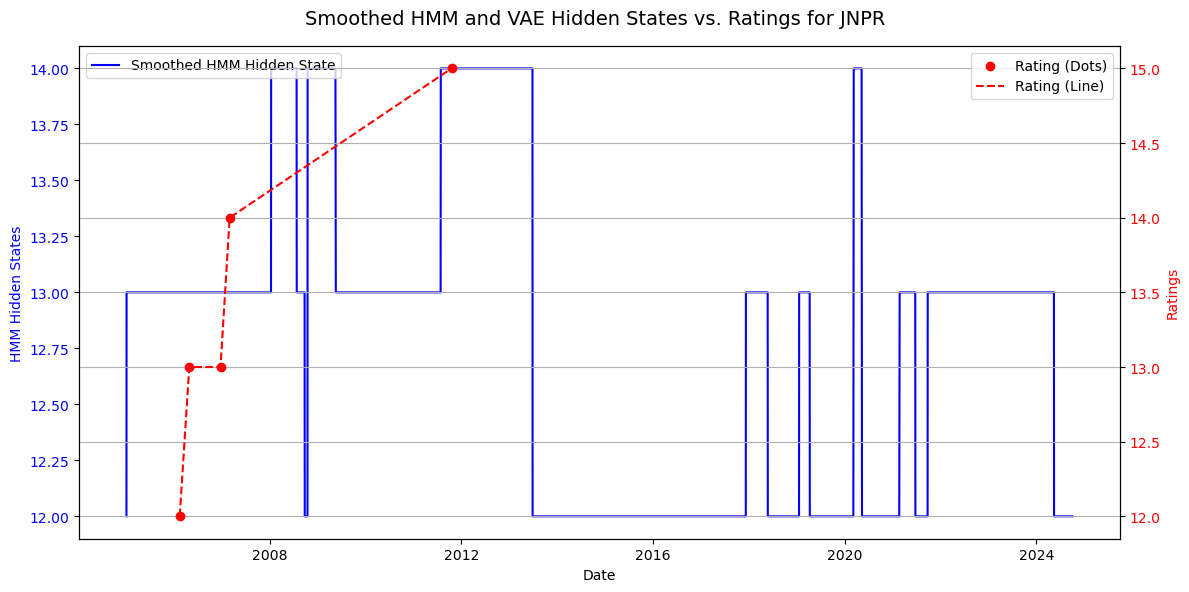

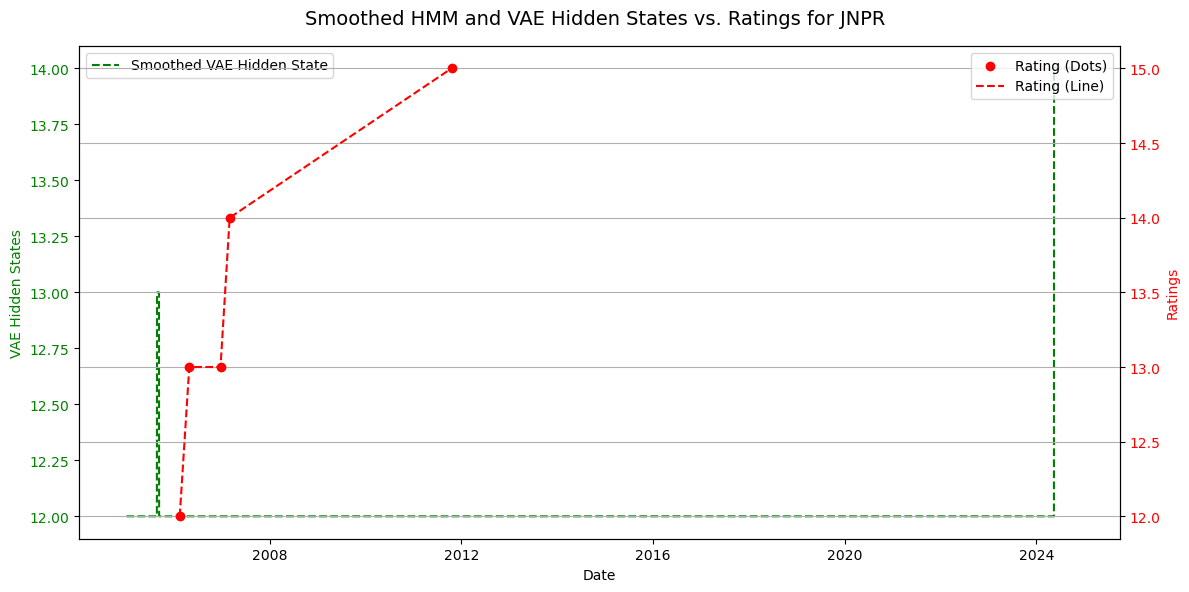

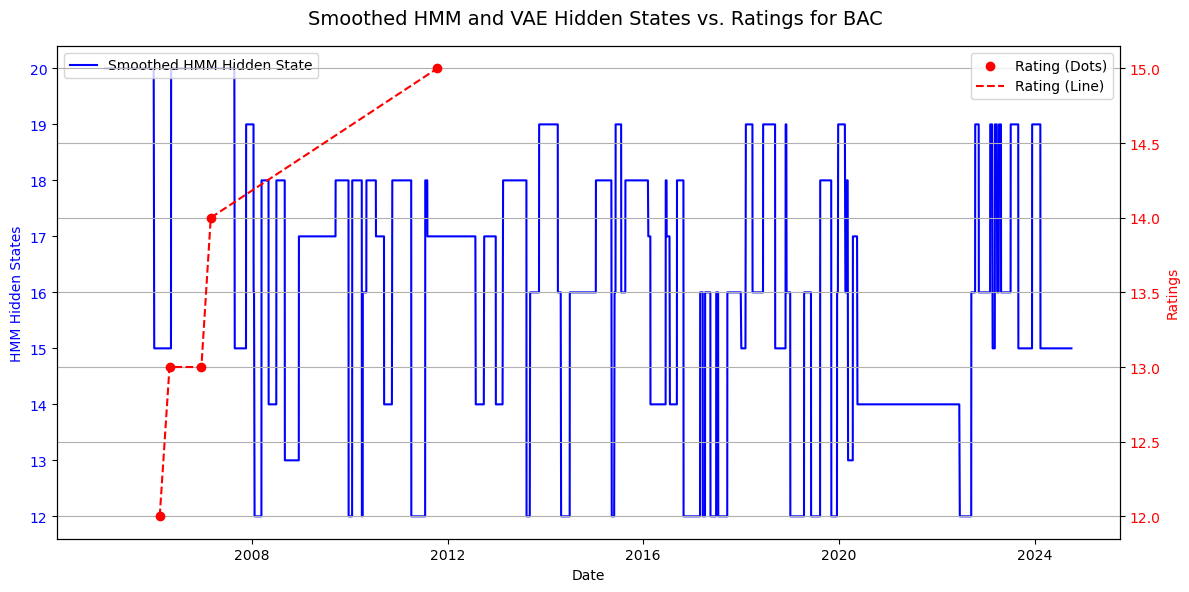

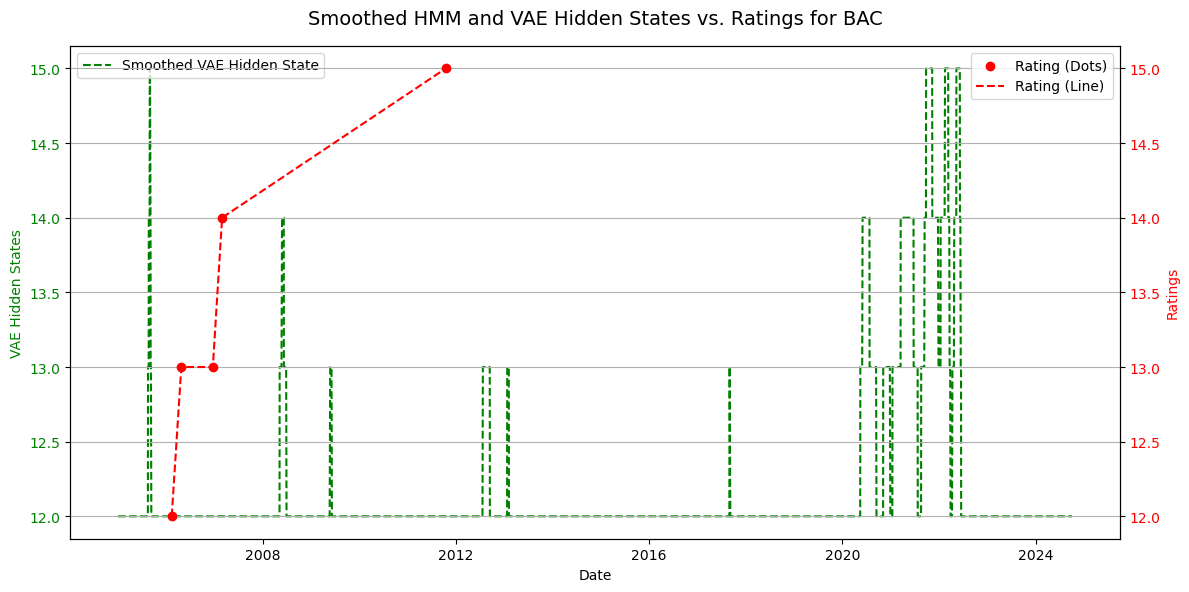

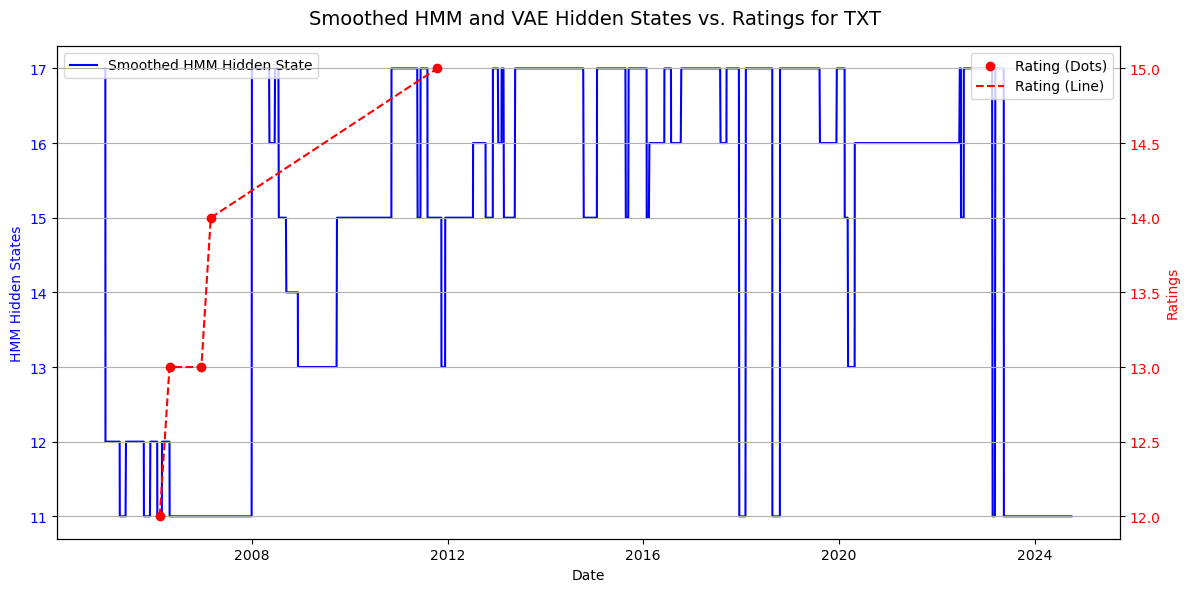

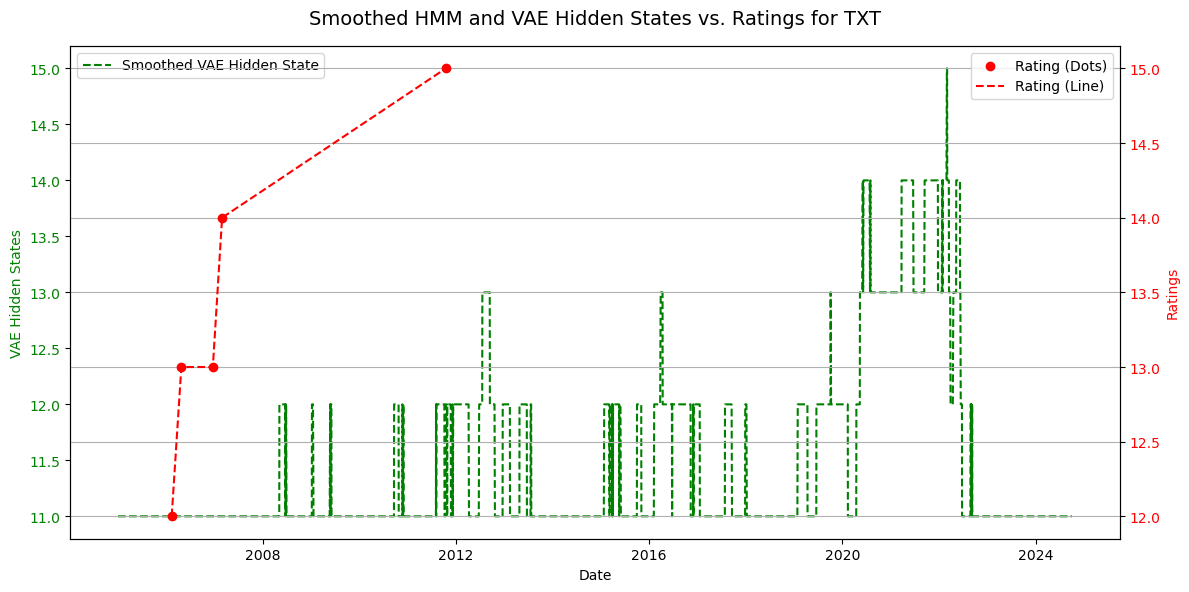

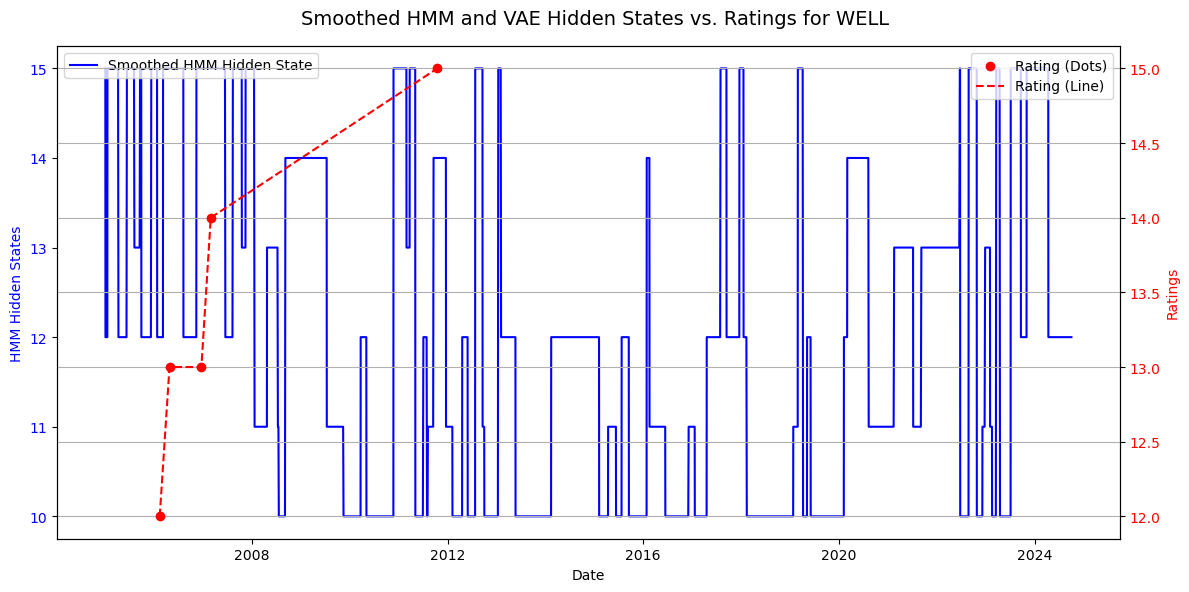

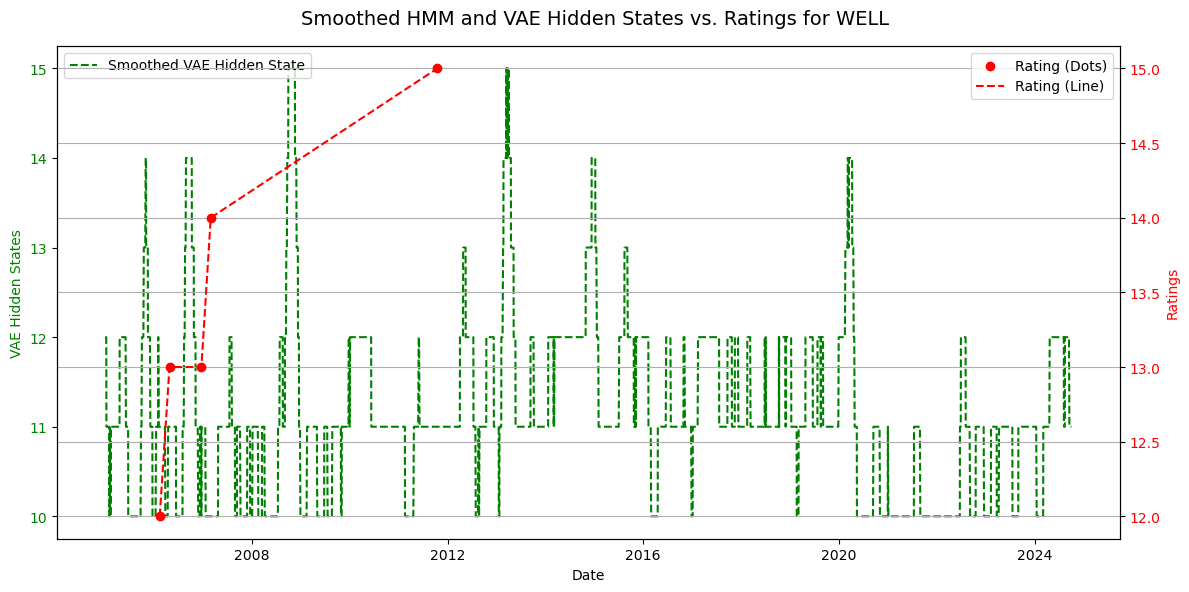

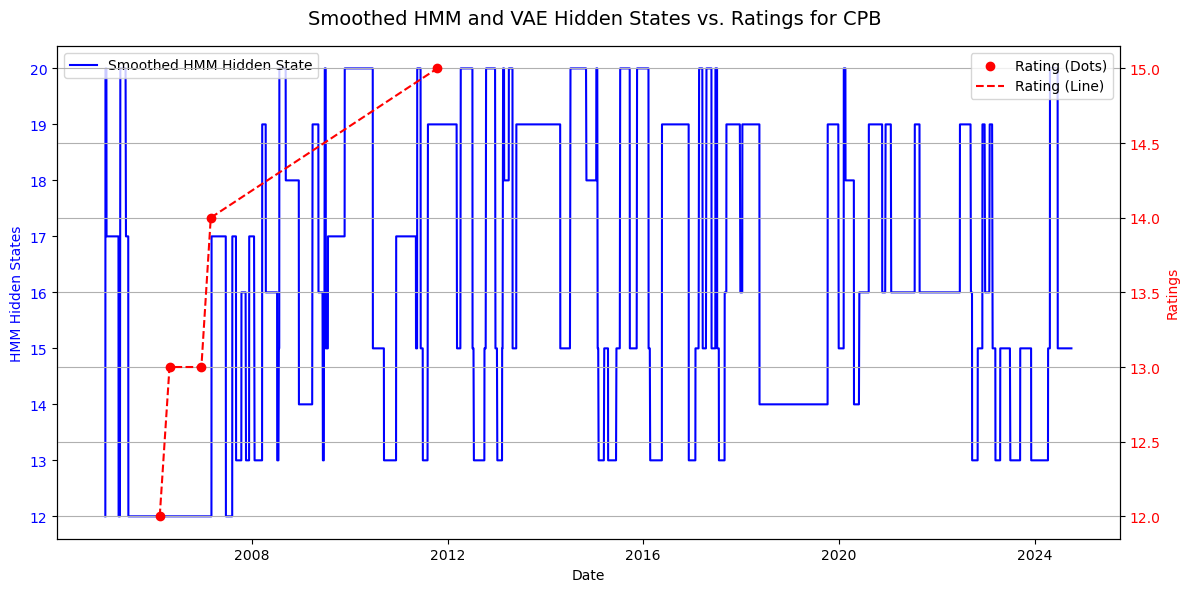

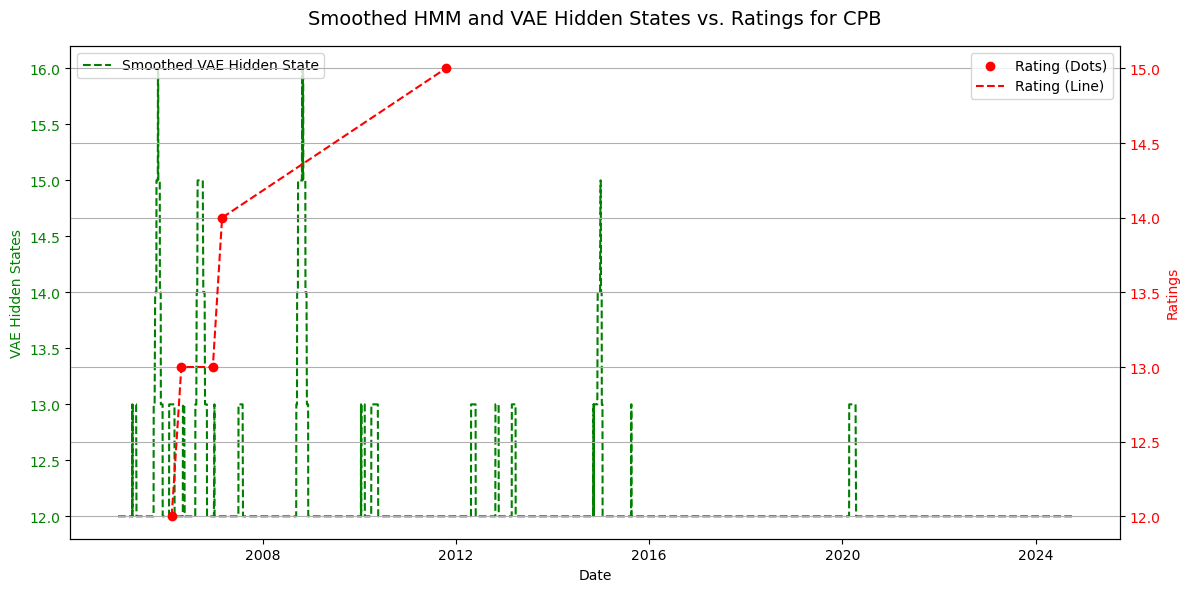

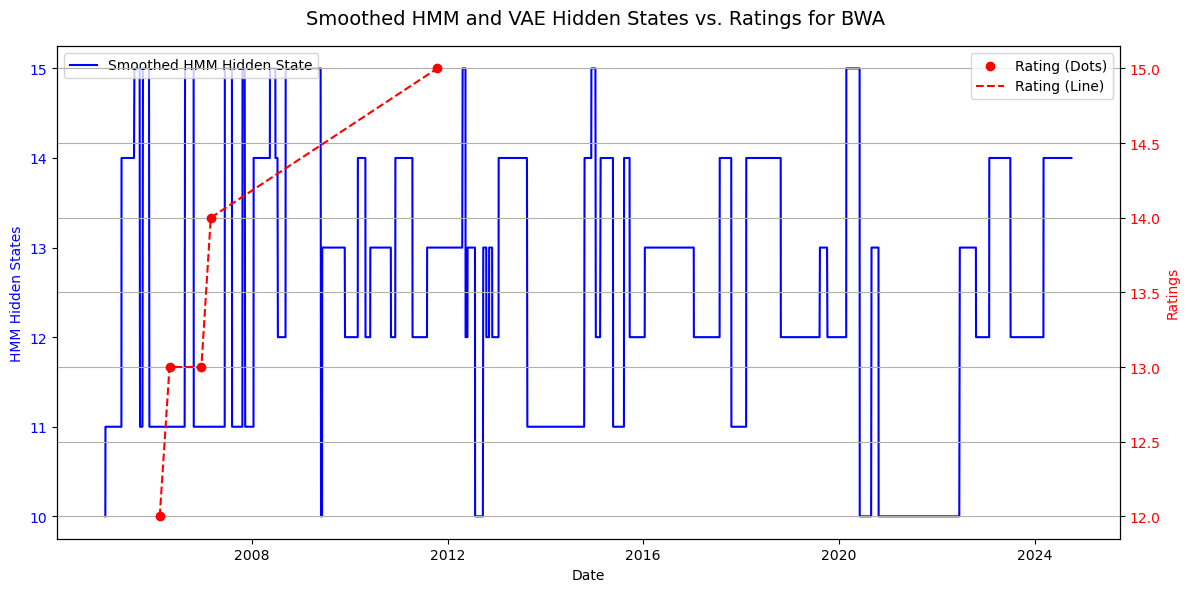

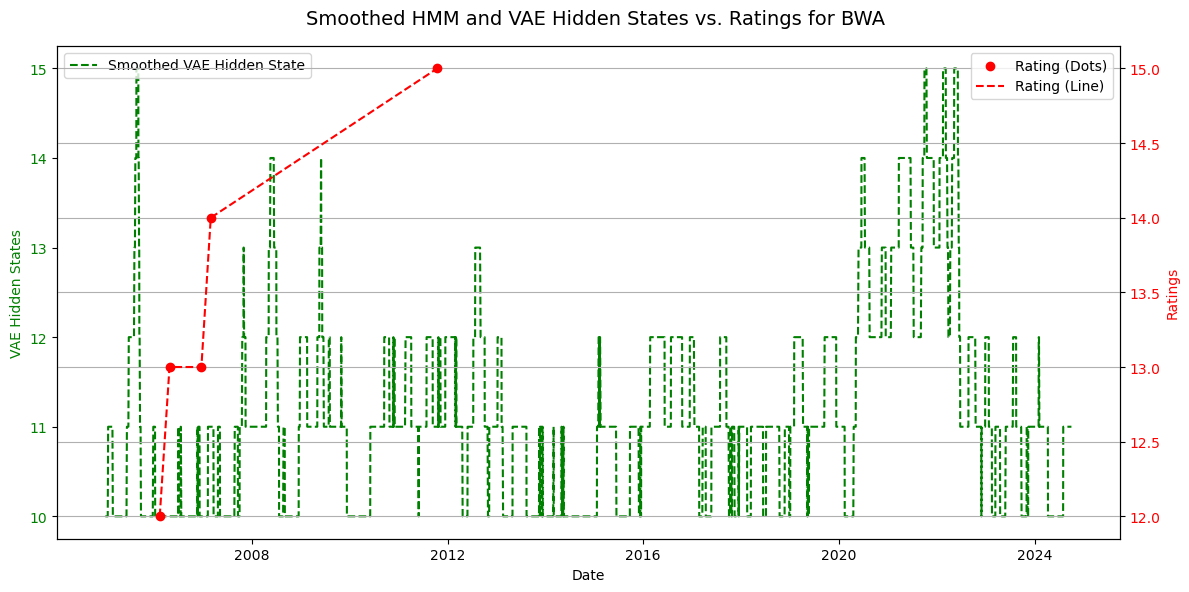

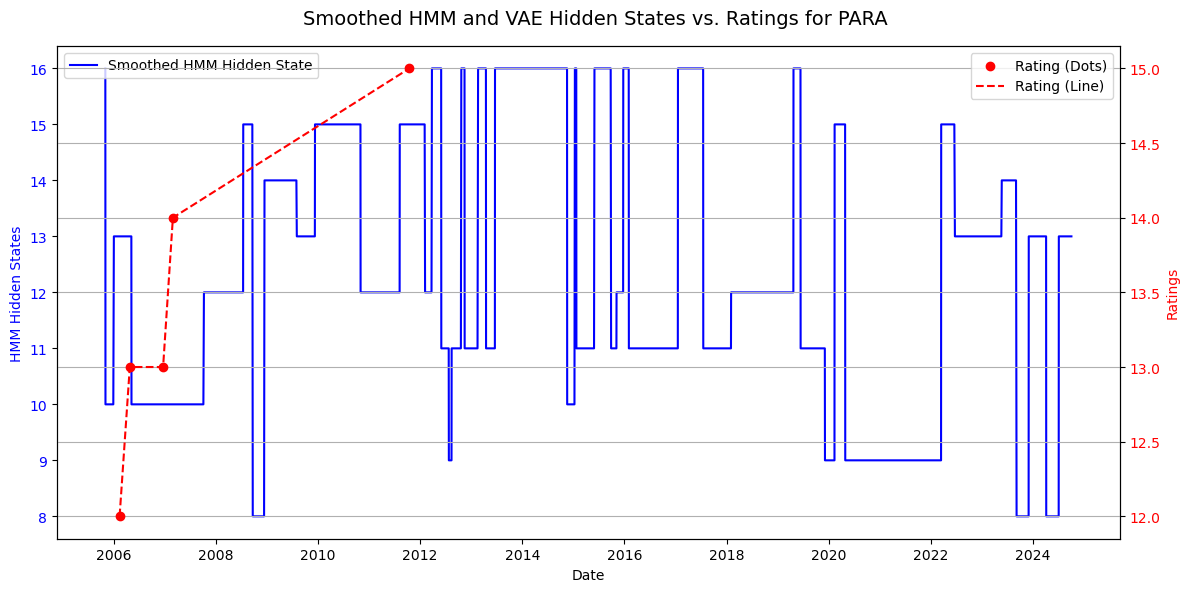

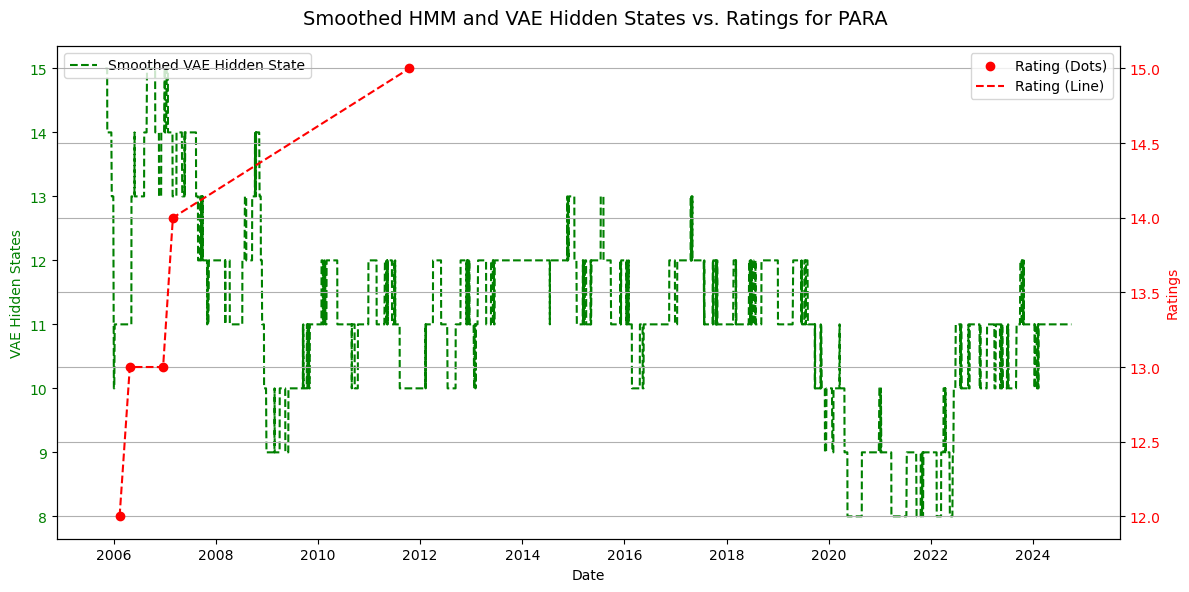

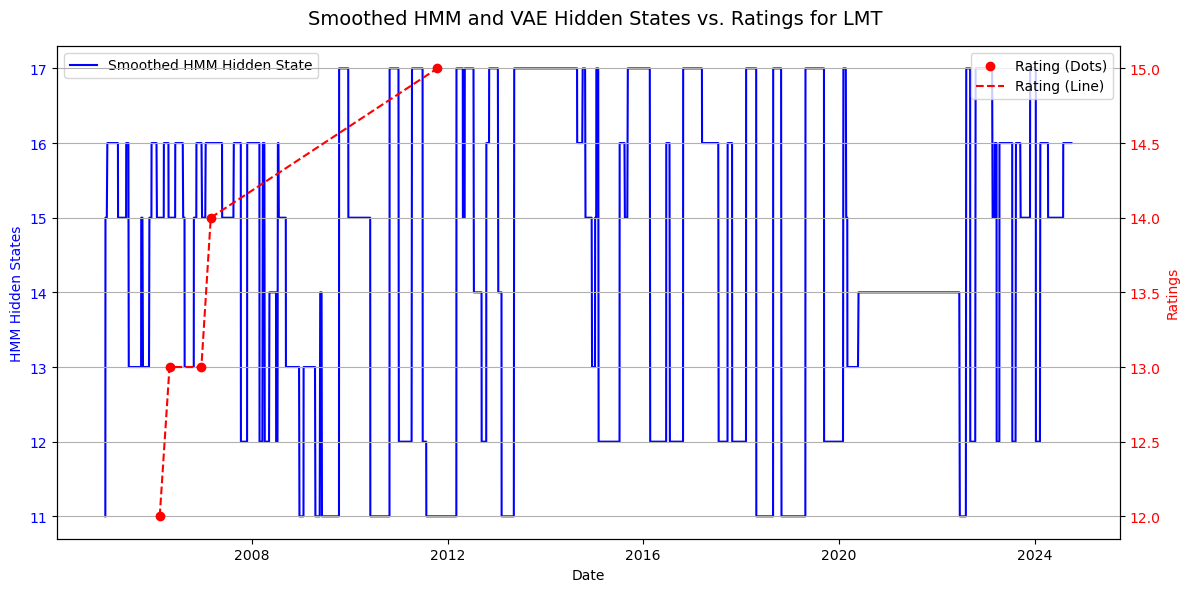

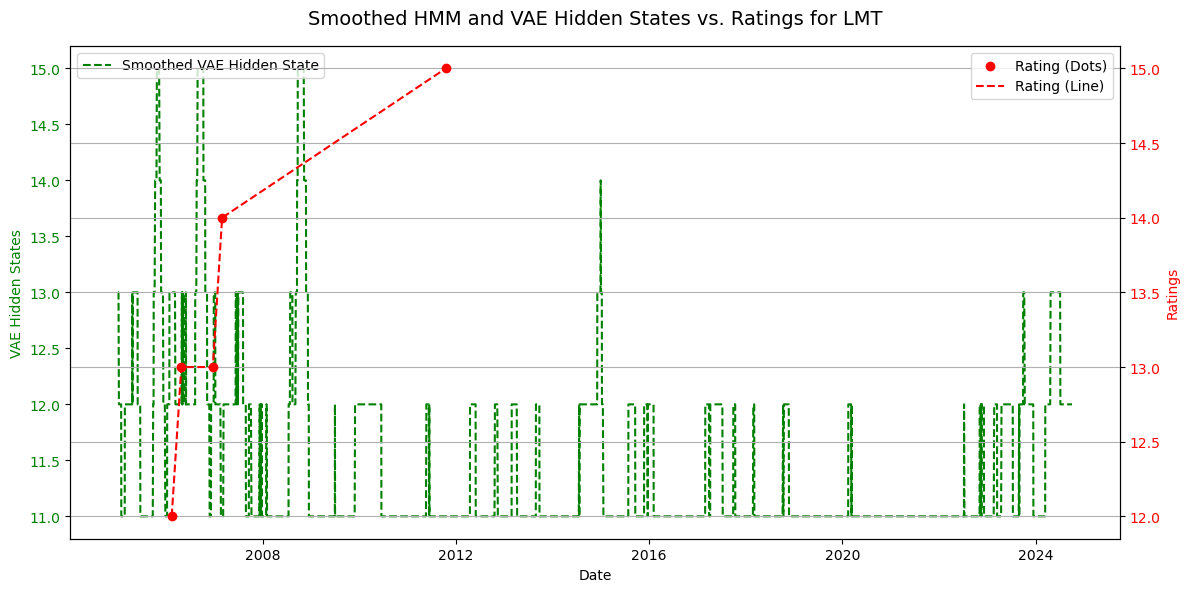

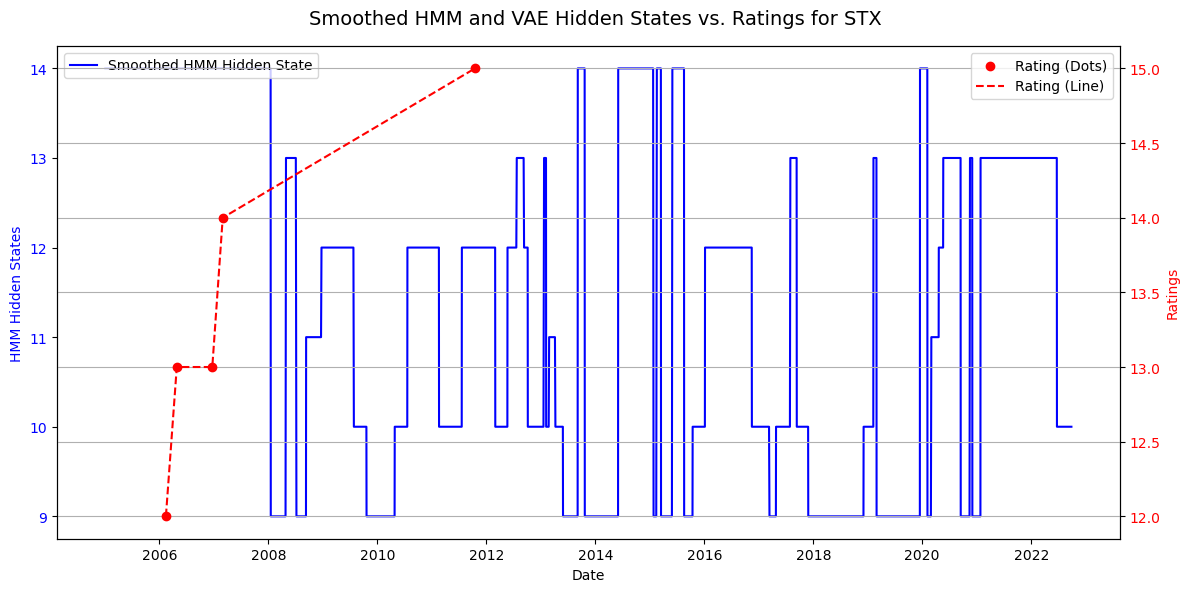

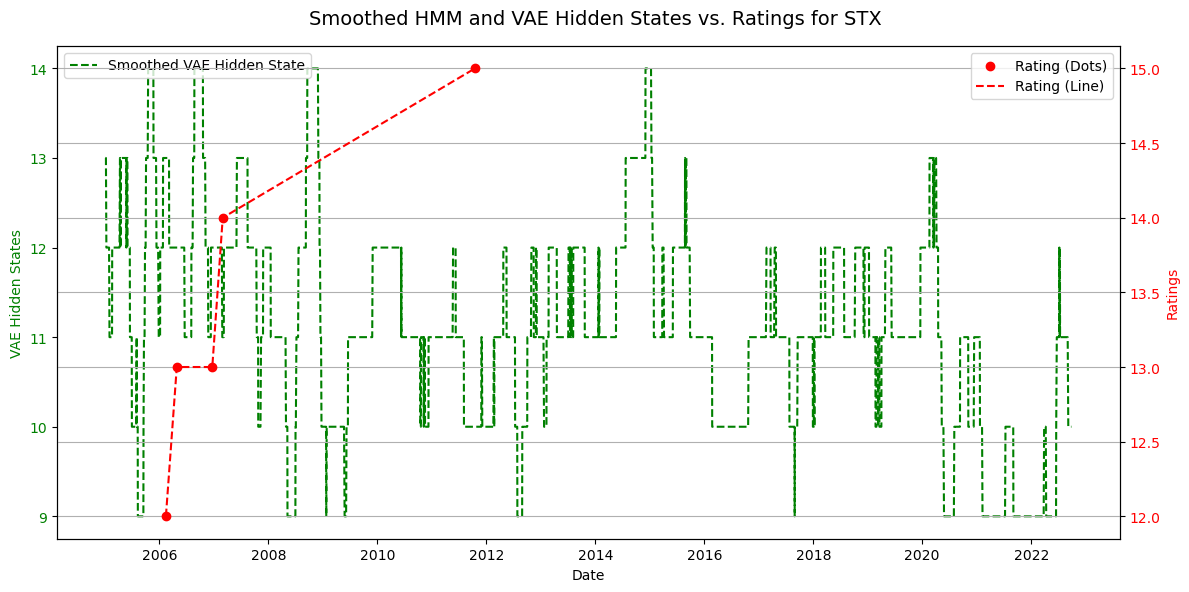

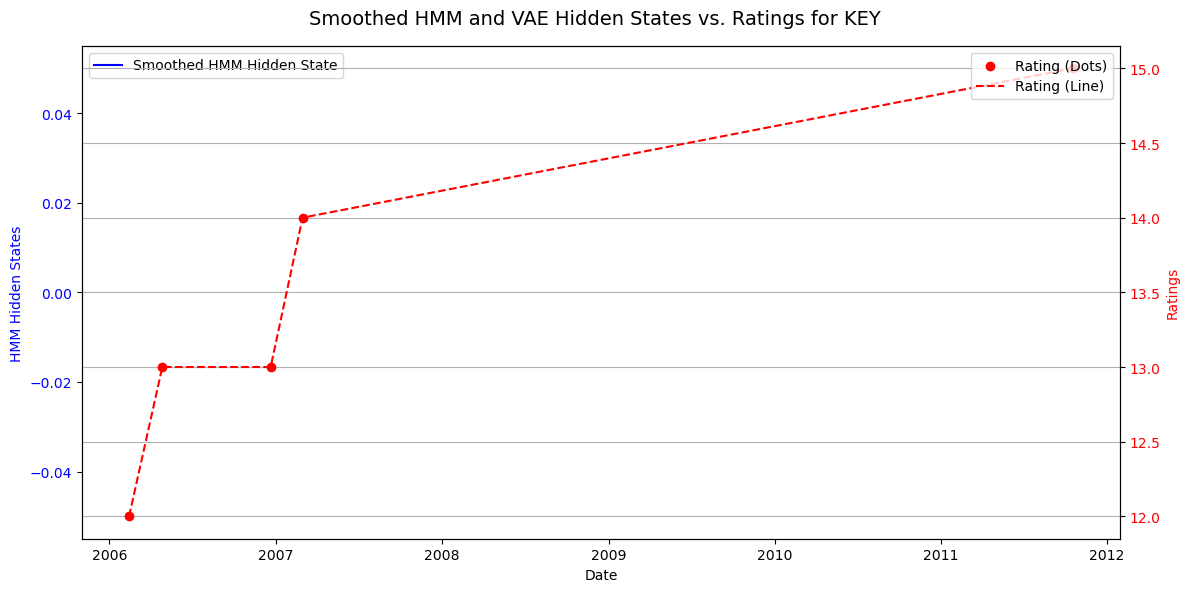

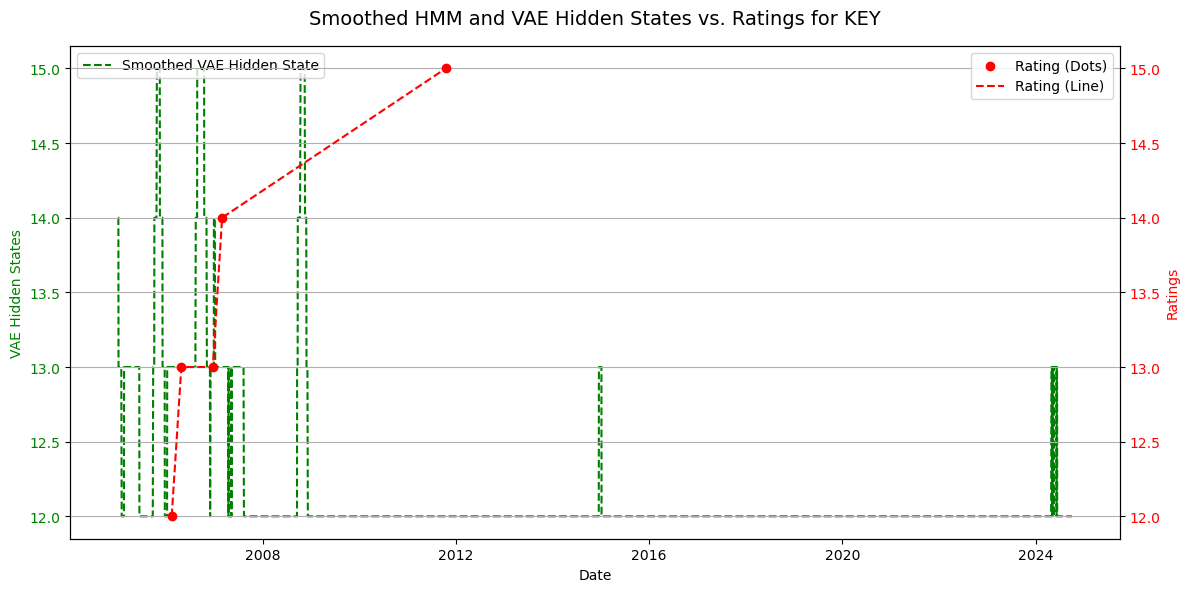

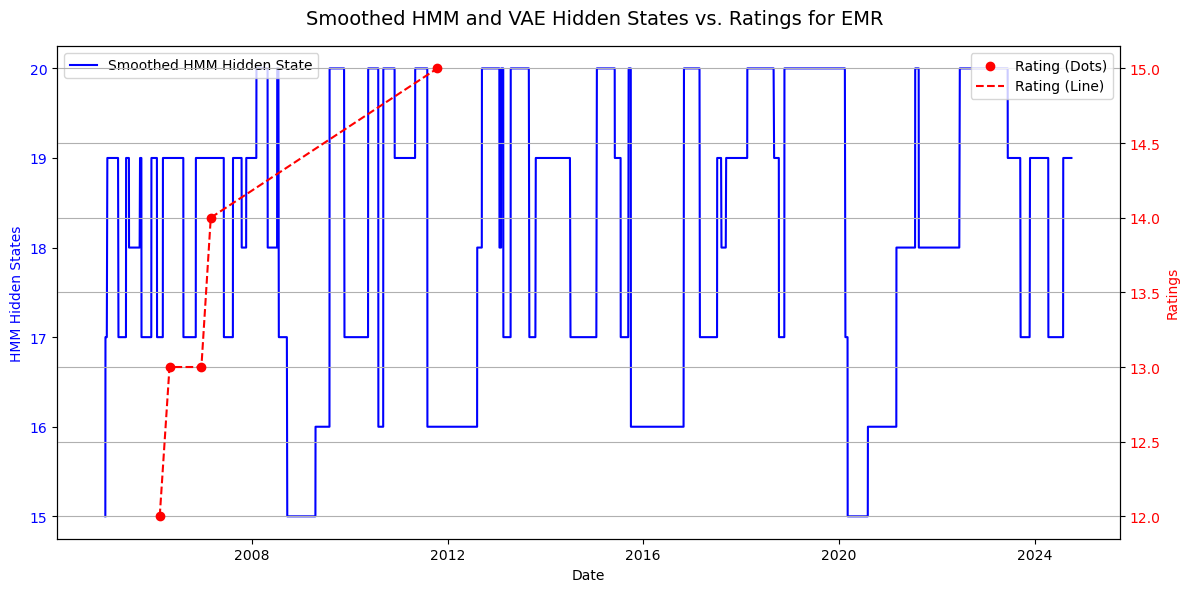

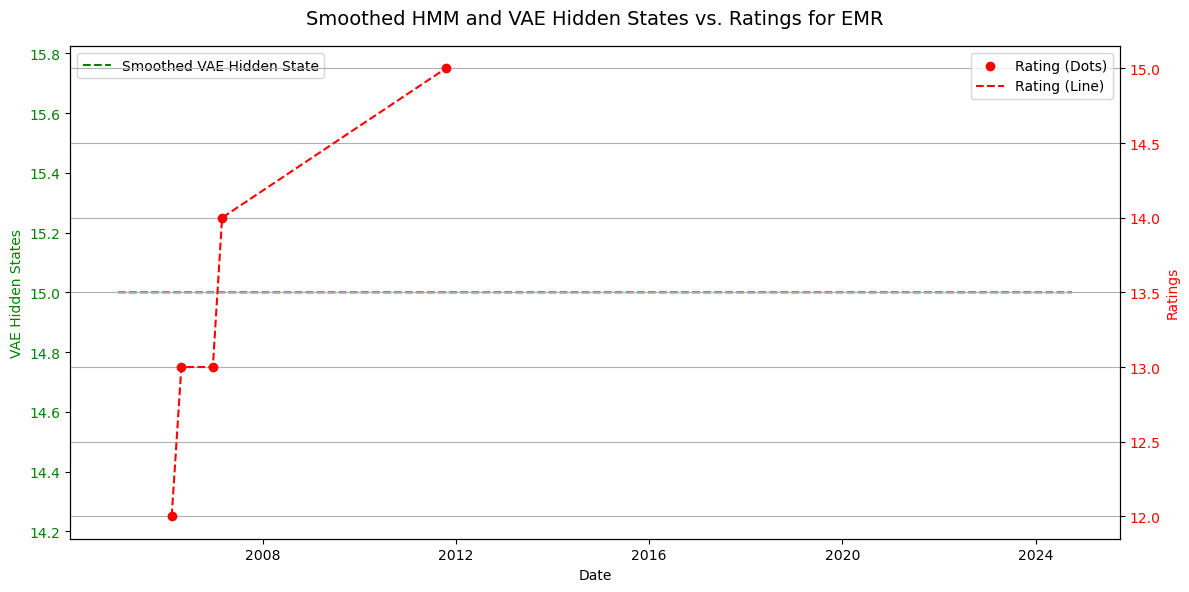

In [124]:
import pandas as pd
import matplotlib.pyplot as plt

# Set a rolling window size (e.g., 30 days)
rolling_window = 100

for company in HMM_DATA['Company'].unique():
    company_data = HMM_DATA[HMM_DATA['Company'] == company].copy()
    #ratings_data = company_data.dropna(subset=['State'])

    # Smooth HMM Hidden States using rolling average
    #company_data['Smoothed_HMM_Hidden_State'] = company_data['Hidden_State'].rolling(window=rolling_window, min_periods=1).mean()
    
    # Smooth VAE Hidden States (average of VAE_Hidden_State_1 and VAE_Hidden_State_2) using rolling average
    '''
    company_data['Combined_VAE_Hidden_State'] = (
        company_data['VAE_Hidden_State_1'] + company_data['VAE_Hidden_State_2']
    ) / 2
    company_data['Smoothed_VAE_Hidden_State'] = company_data['Combined_VAE_Hidden_State'].rolling(window=rolling_window, min_periods=1).mean()
    '''
    # Plot Smoothed HMM Hidden States
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(company_data['Date'], company_data['Hidden_State'], label='Smoothed HMM Hidden State', color='blue')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('HMM Hidden States', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Overlay Historical Ratings
    ax2 = ax1.twinx()
    ax2.scatter(ratings_data['Date'], ratings_data['State'], label='Rating (Dots)', color='red', zorder=5)
    ax2.plot(ratings_data['Date'], ratings_data['State'], label='Rating (Line)', color='red', linestyle='--')
    ax2.set_ylabel('Ratings', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and Legend
    fig.suptitle(f'Smoothed HMM and VAE Hidden States vs. Ratings for {company}', fontsize=14)
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()    

    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.plot(company_data['Date'], company_data['Mapped_Rating'], label='Smoothed VAE Hidden State', color='green', linestyle='--')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('VAE Hidden States', color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    
    
    # Overlay Historical Ratings
    ax2 = ax1.twinx()
    ax2.scatter(ratings_data['Date'], ratings_data['State'], label='Rating (Dots)', color='red', zorder=5)
    ax2.plot(ratings_data['Date'], ratings_data['State'], label='Rating (Line)', color='red', linestyle='--')
    ax2.set_ylabel('Ratings', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Title and Legend
    fig.suptitle(f'Smoothed HMM and VAE Hidden States vs. Ratings for {company}', fontsize=14)
    fig.tight_layout()
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()


In [116]:
merged_df

Date  BB_0YR_DEFAULT_PROB BB_1YR_DEFAULT_PROB BB_2Y_DEFAULT_PROB  \
0     2005-01-03                    0            0.000004           0.000293   
1     2005-01-04                    0            0.000007           0.000385   
2     2005-01-05                    0            0.000007           0.000376   
3     2005-01-06                    0            0.000007           0.000386   
4     2005-01-07                    0            0.000007           0.000385   
...          ...                  ...                 ...                ...   
77323 2024-09-25                    0            0.000001           0.000109   
77324 2024-09-26                    0            0.000001           0.000114   
77325 2024-09-27                    0            0.000001           0.000114   
77326 2024-09-30                    0            0.000001           0.000114   
77327 2024-10-01                    0            0.000001           0.000113   

      BB_3Y_DEFAULT_PROB BB_4Y_DEFAULT_PROB BB_5Y_DEFAULT_PROB  \
0               0.001383            0.00283           0.004748   
1               0.001675           0.003332           0.005458   
2                0.00165           0.003289           0.005399   
3               0.001679           0.003338           0.005468   
4               0.001676           0.003332           0.005458   
...                  ...                ...                ...   
77323           0.000682           0.001559           0.002885   
77324           0.000704           0.001602           0.002955   
77325           0.000702           0.001601           0.002954   
77326             0.0007           0.001597           0.002946   
77327           0.000697           0.001591           0.002938   

      RSK_BB_IMPLIED_CDS_SPREAD  Rate  Pct_Change  ...  Asset_Volatility  \
0                          21.2  4.23   -0.000219  ...          0.038387   
1                          23.3  4.29   -0.000067  ...          0.041405   
2                          23.1  4.29    0.000084  ...          0.041320   
3                          23.3  4.29    0.000236  ...          0.041527   
4                          23.3  4.29    0.000387  ...          0.041533   
...                         ...   ...         ...  ...               ...   
77323                      34.1  3.79    0.002312  ...          0.171349   
77324                      34.1  3.79    0.002334  ...          0.176407   
77325                      34.1  3.75    0.002355  ...          0.176359   
77326                      34.2  3.81    0.002419  ...          0.177033   
77327                      34.2  3.74    0.002441  ...          0.176719   

       Equity_Value_Model  Distance_to_Default  Default_Probability  Company  \
0             1580.528324             6.579069         2.367010e-11      RTN   
1             1585.103878             6.120249         4.671475e-10      RTN   
2             1586.368939             6.141923         4.076413e-10      RTN   
3             1587.612174             6.119987         4.679154e-10      RTN   
4             1588.833412             6.127841         4.453967e-10      RTN   
...                   ...                  ...                  ...      ...   
77323        28047.497116             5.752129         4.406328e-09      EMR   
77324        28063.788676             5.592901         1.116535e-08      EMR   
77325        28073.833382             5.603080         1.052880e-08      EMR   
77326        28134.684725             5.617992         9.659495e-09      EMR   
77327        28140.977303             5.635938         8.705398e-09      EMR   

       Hidden_State  Normalized_Hidden_State  Curr Rtg  Cleaned Rtg  State  
0              12.0                     0.55       NaN          NaN    NaN  
1              12.0                     0.55       NaN          NaN    NaN  
2              12.0                     0.55       NaN          NaN    NaN  
3              12.0                     0.55       NaN          NaN    NaN  